In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
from minisom import MiniSom
from GEMA import Classification, Map
from yellowbrick.cluster import KElbowVisualizer
import warnings
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import plotly.graph_objects as go
from matplotlib.dates import DateFormatter
from matplotlib.ticker import MaxNLocator

warnings.filterwarnings("ignore")
import folium
from folium import plugins

In [2]:
trans_data = pd.read_excel("gec_txn.xlsx")
user_data = pd.read_excel("gec_user_info.xlsx")
geo = pd.read_excel('gec_geography.xlsx', sheet_name='mp_country_code')

# 1. Data cleaning

## 1.1 Bảng trans_data

In [3]:
trans_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139313 entries, 0 to 139312
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   user_id   139055 non-null  float64       
 1   date      139313 non-null  datetime64[ns]
 2   platform  139313 non-null  object        
 3   volume    139313 non-null  float64       
 4   fee       139313 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 5.3+ MB


In [4]:
# loại bỏ các user_id không có thông tin trong bảng user_info
trans_data = trans_data[trans_data['user_id'].isin(user_data['user_id'])]
# Chuyển lại user_id về thành dạng object
trans_data['user_id'] = trans_data['user_id'].astype('object')

In [5]:
trans_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134768 entries, 0 to 139312
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   user_id   134510 non-null  object        
 1   date      134768 non-null  datetime64[ns]
 2   platform  134768 non-null  object        
 3   volume    134768 non-null  float64       
 4   fee       134768 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 6.2+ MB


In [6]:
# Loại bỏ dữ liệu thiếu user_id
trans_data.dropna(inplace = True, subset= 'user_id')

In [7]:
trans_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134510 entries, 0 to 139312
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   user_id   134510 non-null  object        
 1   date      134510 non-null  datetime64[ns]
 2   platform  134510 non-null  object        
 3   volume    134510 non-null  float64       
 4   fee       134510 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 6.2+ MB


## 1.2 Bảng user_data

In [8]:
user_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122314 entries, 0 to 122313
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   user_id           98272 non-null   float64       
 1   platform          122314 non-null  object        
 2   city              111329 non-null  object        
 3   os                122314 non-null  object        
 4   mp_country_code   122276 non-null  object        
 5   time              122314 non-null  datetime64[ns]
 6   date              47203 non-null   datetime64[ns]
 7   feature           47203 non-null   float64       
 8   session           47203 non-null   float64       
 9   time_per_session  47203 non-null   float64       
dtypes: datetime64[ns](2), float64(4), object(4)
memory usage: 9.3+ MB


In [9]:
user_data['user_id'] = user_data['user_id'].astype('object')

In [10]:
user_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122314 entries, 0 to 122313
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   user_id           98272 non-null   object        
 1   platform          122314 non-null  object        
 2   city              111329 non-null  object        
 3   os                122314 non-null  object        
 4   mp_country_code   122276 non-null  object        
 5   time              122314 non-null  datetime64[ns]
 6   date              47203 non-null   datetime64[ns]
 7   feature           47203 non-null   float64       
 8   session           47203 non-null   float64       
 9   time_per_session  47203 non-null   float64       
dtypes: datetime64[ns](2), float64(3), object(5)
memory usage: 9.3+ MB


In [11]:
user_data.isnull().sum()

user_id             24042
platform                0
city                10985
os                      0
mp_country_code        38
time                    0
date                75111
feature             75111
session             75111
time_per_session    75111
dtype: int64

-> Các trường dữ liệu bị thiếu rất nhiều

In [12]:
user_data.dropna(subset= 'user_id', axis = 0, inplace = True)

In [13]:
user_data.isnull().sum()

user_id                 0
platform                0
city                 8092
os                      0
mp_country_code        29
time                    0
date                56891
feature             56891
session             56891
time_per_session    56891
dtype: int64

->Các giá trị null của trường user_id được loại bỏ

In [14]:
#Số data bị null chia theo năm của cột Session
user_data[user_data.session.isnull()].groupby(pd.Grouper(key = 'time', freq = 'Y'))['user_id'].count()

time
2022-12-31    53610
2023-12-31     3281
Freq: A-DEC, Name: user_id, dtype: int64

In [15]:
#Số data bị null chia theo năm của cột Feature
user_data[user_data.feature.isnull()].groupby(pd.Grouper(key = 'time', freq = 'Y'))['user_id'].count()

time
2022-12-31    53610
2023-12-31     3281
Freq: A-DEC, Name: user_id, dtype: int64

In [16]:
#Số data bị null chia theo năm của cột time_per_session
user_data[user_data.time_per_session.isnull()].groupby(pd.Grouper(key = 'time', freq = 'Y'))['user_id'].count()

time
2022-12-31    53610
2023-12-31     3281
Freq: A-DEC, Name: user_id, dtype: int64

Số record của năm 2022 là 53160 và tất cả các giá trị liên quan đến app behaviour() của user đều bị <b> null </b> vì vậy việc phân tích nhóm này không mang lại giá trị cho việc phân tích <b> -> loại bỏ các record trong năm 2022 </b>

In [17]:
user_old = user_data.copy()

In [18]:
# Lọc các giao dịch của năm 2022
user_data = user_data[~(user_data['time'] < '2023')]
# Loại bỏ cột date (cột date mang thông tin giống cột time nhưng có nhiều giá trị null 
user_data.drop(labels = 'date', axis = 1, inplace = True)

In [19]:
user_data

user_id platform              city       os mp_country_code       time  \
1      15664.0   mobile              Coro  Windows              VE 2023-02-23   
2        440.0   mobile             Dhaka  Android              BD 2023-02-08   
3       8449.0   mobile        Copenhagen  Windows              DK 2023-02-13   
4      20791.0      web  Ho Chi Minh City    Linux              VN 2023-02-06   
5      29428.0   mobile        Yogyakarta  Android              ID 2023-02-27   
...        ...      ...               ...      ...             ...        ...   
59111    319.0   mobile              Coro  Android              VE 2023-01-03   
59112   4455.0   mobile              Coro  Android              VE 2023-01-03   
59119  30474.0   mobile              Coro  Android              VE 2023-01-03   
59126  24528.0   mobile         Pekanbaru  Android              ID 2023-01-02   
59139  34991.0   mobile  Ho Chi Minh City  Android              VN 2023-01-01   

       feature  session  time_per_session  
1          2.0      1.0         65.000000  
2          5.0      3.0        425.363636  
3          NaN      NaN               NaN  
4          NaN      NaN               NaN  
5          3.0      1.0         86.000000  
...        ...      ...               ...  
59111      3.0      1.0         15.000000  
59112      3.0      1.0         18.000000  
59119      3.0      1.0         12.000000  
59126      4.0      1.0        441.000000  
59139      2.0      1.0          0.000000  

[44662 rows x 9 columns]

## 1.3 Bảng Geography

In [20]:
geo.isnull().sum()

Country                0
Alpha-2_code           0
Latitude_(average)     1
Longitude_(average)    1
dtype: int64

In [21]:
geo.dropna(inplace = True )

In [22]:
geo.groupby('Alpha-2_code')['Country'].count().sort_values()

Alpha-2_code
"AD"    1
"MY"    1
"MZ"    1
"NA"    1
"NC"    1
       ..
"BN"    2
"BO"    2
"VE"    2
"KR"    2
"VC"    3
Name: Country, Length: 244, dtype: int64

-> Dữ liệu của một số quốc gia bị lặp lại 

In [23]:
geo.drop_duplicates(subset = 'Alpha-2_code', inplace = True)

In [24]:
geo['Alpha-2_code'] = geo['Alpha-2_code'].str.replace("\"", "")
geo['Latitude_(average)'] = geo['Latitude_(average)'].str.replace("\"", "")
geo['Longitude_(average)'] = geo['Longitude_(average)'].str.replace("\"", "")

# 2. App Overview

## 2.1 Transaction Data Overview

In [25]:
data = trans_data.copy()

In [26]:
data['day'] = data['date'].dt.day
data['month'] = data['date'].dt.month
data['week'] = data['date'].dt.isocalendar().week
data['week_day'] = data['date'].dt.strftime('%A')

In [27]:
#week_volume calculation
data_week_volume = pd.merge(data
             , data.groupby(['user_id', 'week'])['volume'].sum()
             , how='inner'
             , on = ['user_id', 'week']
             ,suffixes=('','_y')
            ).sort_values(by = ['user_id', 'week'])
data_week_volume = data_week_volume.rename(columns={'volume_y':'week_volume'})
data_week_volume.head(1)

user_id       date platform     volume  fee  day  month  week week_day  \
25859     4.0 2023-01-29      web  27.560834  0.0   29      1     4   Sunday   

       week_volume  
25859   580.224688

In [28]:
# calculate week_count (weekly trading frequency)
temp_week = pd.DataFrame(data.groupby(['user_id', 'week'])['user_id'].count())
temp_week = temp_week.rename(columns={'user_id': 'week_count'})
data_week_fre = pd.merge(data_week_volume
             , temp_week
             , how='inner'
             , on = ['user_id', 'week']
             ,suffixes=('','_y')
            ).sort_values(by = 'user_id')
data_week_fre.head(5)

user_id       date platform     volume  fee  day  month  week  week_day  \
0      4.0 2023-01-29      web  27.560834  0.0   29      1     4    Sunday   
75     4.0 2023-02-25      web  50.563921  0.0   25      2     8  Saturday   
74     4.0 2023-02-26      web  52.956094  0.0   26      2     8    Sunday   
73     4.0 2023-02-23      web  52.462481  0.0   23      2     8  Thursday   
72     4.0 2023-02-24      web  50.409149  0.0   24      2     8    Friday   

    week_volume  week_count  
0    580.224688          22  
75  3499.509988          68  
74  3499.509988          68  
73  3499.509988          68  
72  3499.509988          68

In [29]:
def count_by_date(count_by_date_df, tick_font_scale, axis_fontsize, tlt_fontsize, figsize, maxXticks, x_label, y_label, title, 
                  highlight_date_1_start, highlight_date_1_end, highlight_date_2_start, highlight_date_2_end, bottom):
    sns.set(style='ticks', font_scale = tick_font_scale)
    fig, ax = plt.subplots(figsize=figsize)
    sns.lineplot(x = count_by_date_df.index, y=count_by_date_df.values, color='#15a390', ax=ax)
    date_form = DateFormatter("%d-%m")
    ax.xaxis.set_major_formatter(date_form)
    plt.xlabel(x_label, fontsize = axis_fontsize)
    plt.ylabel(y_label, fontsize = axis_fontsize)
    title = plt.title(title, fontsize = tlt_fontsize)
    ax.xaxis.set_major_locator(MaxNLocator(maxXticks))
    title.set_fontweight('bold')
    # Add a shaded region to highlight a specific part of the plot
    start_date_1 = pd.to_datetime(highlight_date_1_start)
    end_date_1 = pd.to_datetime(highlight_date_1_end)
    start_date_2 = pd.to_datetime(highlight_date_2_start)
    end_date_2 = pd.to_datetime(highlight_date_2_end)
    ax.fill_between(x=count_by_date_df.index, y1=count_by_date_df.values, 
                    where=(count_by_date_df.index >= start_date_1) & 
                    (count_by_date_df.index <= end_date_1), color='#3B8052', alpha=0.3)
    ax.fill_between(x=count_by_date_df.index, y1=count_by_date_df.values, 
                    where=(count_by_date_df.index >= start_date_2) & 
                    (count_by_date_df.index <= end_date_2), color='#3B8052', alpha=0.3)
    ax.set_ylim(bottom=bottom)

In [30]:
## Users, Transactions and Volume by date

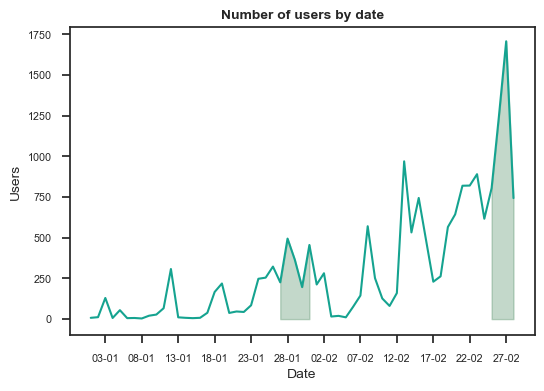

In [31]:
user_count_df = data_week_fre.groupby('date')['user_id'].nunique()
count_by_date(user_count_df, 0.7, 10, 10, (6,4), 15, 'Date', 'Users', 'Number of users by date', '2023-01-27', '2023-01-31', '2023-02-25', '2023-02-28', -100)
plt.savefig('Number of transactions by date.png')

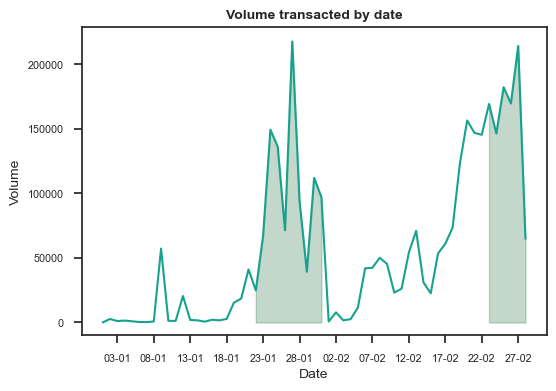

In [32]:
sum_by_date = data_week_fre.groupby('date')['volume'].sum()
count_by_date(sum_by_date, 0.7, 10, 10, (6,4), 15, 'Date', 'Volume', 'Volume transacted by date', '2023-01-22', '2023-01-31', '2023-02-23', '2023-02-28', -10000)
plt.savefig('[Gcon] Volume transacted by date.png')

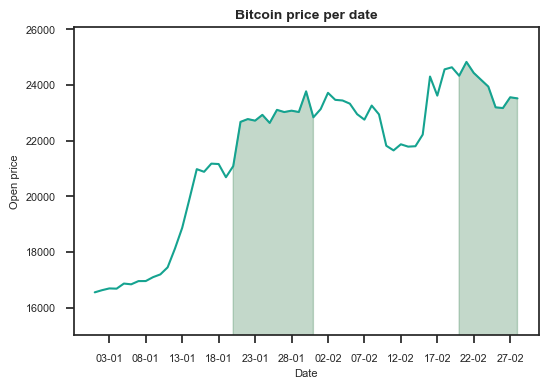

In [33]:
# Bitcoin price
btc_df = pd.read_csv(r"C:\Users\admin\Desktop\G'contest\Vòng 3\BTC-USD.csv", usecols = ['Date', 'Open'])
btc_df['Date'] = btc_df['Date'].apply(lambda x: pd.to_datetime(x, format='%d/%m/%Y'))
btc_df = btc_df.dropna()
btc_df = btc_df.set_index(btc_df.columns[0]).squeeze()
count_by_date(btc_df, 0.7, 8, 10, (6,4), 15, 'Date', 'Open price', 'Bitcoin price per date', '2023-01-20', '2023-01-31', '2023-02-20', '2023-02-28', 15000)
plt.savefig('[Gcon] Bitcoin price per date.png')

In [34]:
## Compare monthly performance

In [35]:
transaction_value = data_week_fre.groupby(['user_id','month'])['volume'].sum().reset_index()
transaction_value

user_id  month       volume
0         4.0      1   580.224688
1         4.0      2  4130.233306
2        23.0      2     0.182284
3        24.0      2     0.812294
4        28.0      1    10.123025
...       ...    ...          ...
6744  30644.0      1  1038.607788
6745  30645.0      2     0.000031
6746  30669.0      2     0.000020
6747  30679.0      1     5.741073
6748  30679.0      2     0.150079

[6749 rows x 3 columns]

In [36]:
# Filter outliers from transaction volume:
q = transaction_value["volume"].quantile(0.99)
transaction_value_remove_outliers = transaction_value[transaction_value["volume"] < q]

In [37]:
def violin_plot(data, feature, axis_fontsize, tlt_fontsize, x_label, y_label, title):
    sns.violinplot(data=data, x= "month", y= feature, split=True, palette={1: '#1de9b6', 2: '#15a390'})
    plt.xlabel(x_label, fontsize = axis_fontsize)
    plt.ylabel(y_label, fontsize = axis_fontsize)
    title = plt.title(title, fontsize = tlt_fontsize)
    title.set_fontweight('bold')

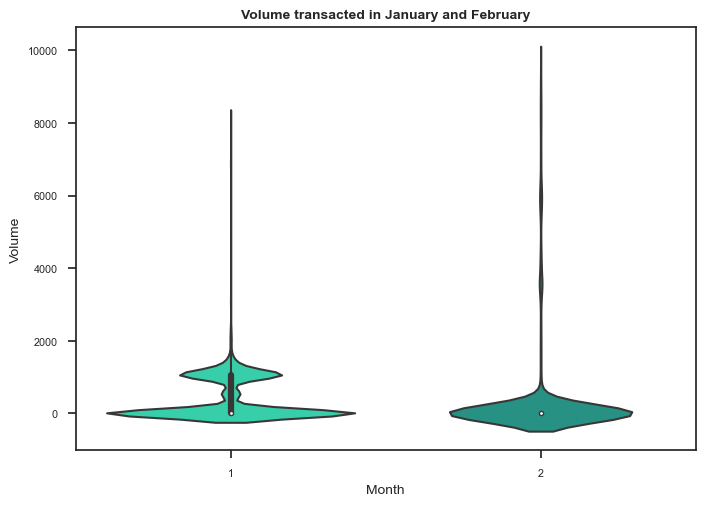

In [38]:
violin_plot(transaction_value_remove_outliers, 'volume', 10, 10, 'Month', 'Volume', 'Volume transacted in January and February')
plt.savefig('[Gcon] Volume transacted by month.png')

In [39]:
transaction_count = data_week_fre[['user_id', 'date', 'month', 'volume']].groupby(['user_id', 'month']).size().reset_index()
transaction_count

user_id  month   0
0         4.0      1  22
1         4.0      2  80
2        23.0      2  35
3        24.0      2  37
4        28.0      1   2
...       ...    ...  ..
6744  30644.0      1   1
6745  30645.0      2  10
6746  30669.0      2  10
6747  30679.0      1   5
6748  30679.0      2   3

[6749 rows x 3 columns]

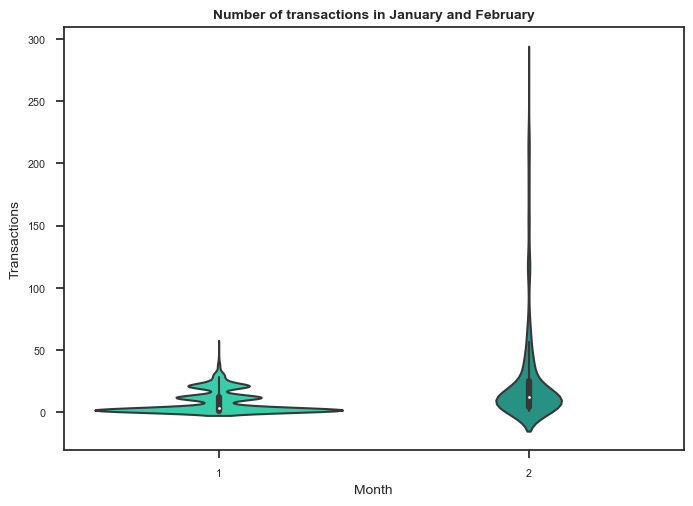

In [40]:
violin_plot(transaction_count, 0, 10, 10, 'Month', 'Transactions', 'Number of transactions in January and February')
plt.savefig('[Gcon] Number of transactions by month.png')

In [41]:
# Platform usage
volume_platform = data_week_fre.groupby('platform')['volume'].sum().round(2).reset_index()
transacts_platform = data_week_fre.groupby('platform').size().reset_index()
users_platform = data_week_fre.groupby('platform')['user_id'].nunique().reset_index()

In [42]:
def bar_chart(data, value, x_label, y_label, title):
    plt.bar(data['platform'], data[value], color='#1de9b6', width = 0.5)
    for x, y in zip(data['platform'], data[value]):
        plt.text(x, y, str(y), ha='center', va='bottom')
    plt.xlabel(x_label, fontsize = 10)
    plt.ylabel(y_label, fontsize = 10)
    plt.tick_params(axis= 'x', labelsize = 12)
    title = plt.title(title, fontsize = 12)
    title.set_fontweight('bold')

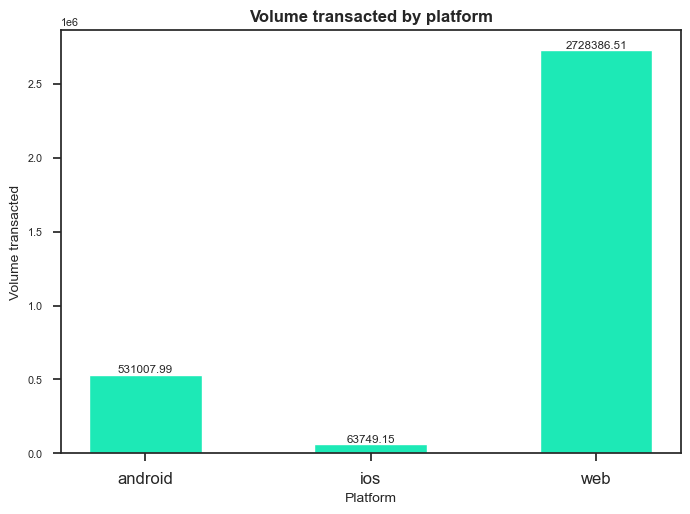

In [43]:
bar_chart(volume_platform, 'volume', 'Platform', 'Volume transacted', 'Volume transacted by platform')
plt.savefig('[Gcon] Volume transacted by platform.png')

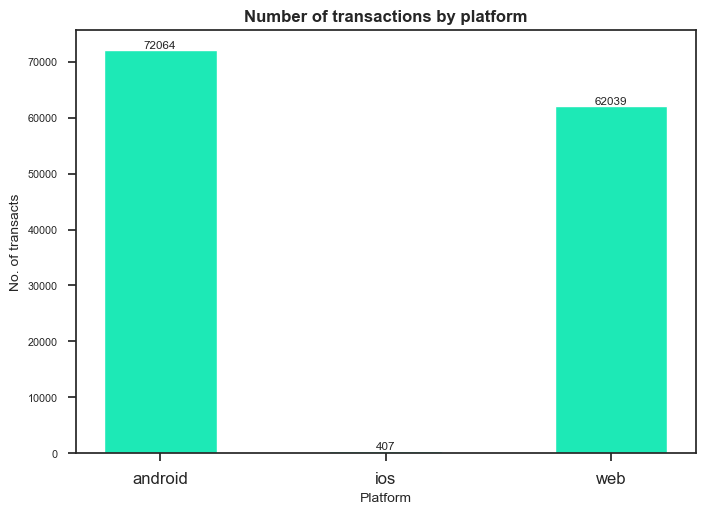

In [44]:
bar_chart(transacts_platform, 0, 'Platform', 'No. of transacts', 'Number of transactions by platform')
plt.savefig('[Gcon] Number of transactions by platform.png')

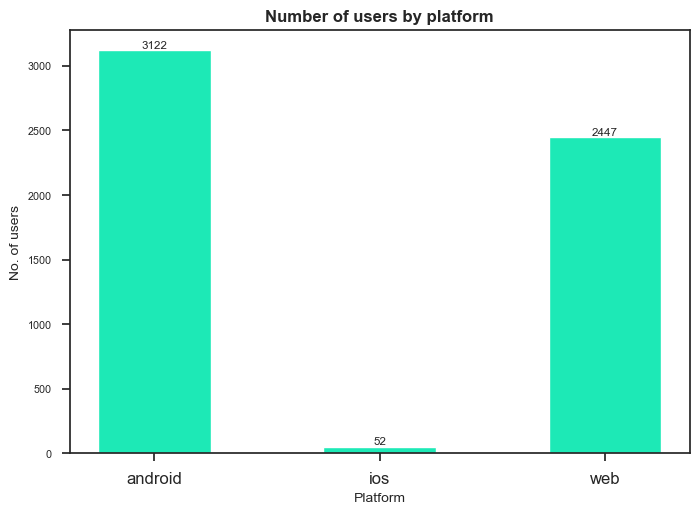

In [45]:
bar_chart(users_platform, 'user_id', 'Platform', 'No. of users', 'Number of users by platform')
plt.savefig('[Gcon] Number of users by platform.png')

In [46]:
x = data.groupby('platform')['user_id'].count()/len(data)

In [47]:
y = data.groupby('platform')['volume'].sum()/data['volume'].sum()

In [48]:
z = data.groupby('platform')['volume'].mean().rename('z')
z

platform
android      7.368561
ios        156.631830
web         43.978570
Name: z, dtype: float64

In [49]:
summary = pd.concat([x,y,z], axis= 1)
summary = summary.rename(columns={'user_id': 'Tỉ trọng số lượng giao dịch', 'volume':'Tỉ trọng giá trị giao dịch',  'z':'Giá trị trung bình mỗi giao dịch'})

In [50]:
summary['Tỉ trọng số lượng giao dịch'] = summary['Tỉ trọng số lượng giao dịch'].map('{:.2%}'.format)
summary['Tỉ trọng giá trị giao dịch'] = summary['Tỉ trọng giá trị giao dịch'].map('{:.2%}'.format)

In [51]:
summary

Tỉ trọng số lượng giao dịch Tỉ trọng giá trị giao dịch  \
platform                                                          
android                       53.58%                     15.98%   
ios                            0.30%                      1.92%   
web                           46.12%                     82.10%   

          Giá trị trung bình mỗi giao dịch  
platform                                    
android                           7.368561  
ios                             156.631830  
web                              43.978570

(-1.9734289328383854, 10.0)

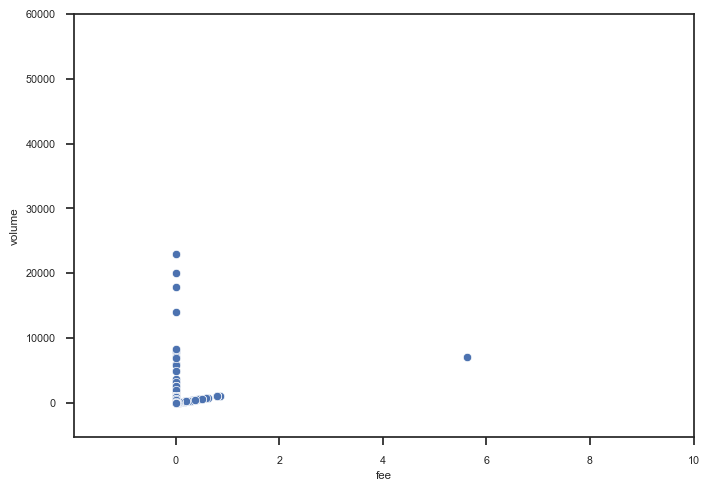

In [52]:
sns.scatterplot(data, x = 'fee', y = 'volume')
plt.ylim(top = 60000)
plt.xlim(right = 10)

## 2.2 User Info Overview

#### Tổng quan theo quốc gia

In [53]:
user_overview = pd.merge(left = user_data, right = geo, left_on='mp_country_code', right_on ='Alpha-2_code')

In [54]:
green_palette = ['#1f9e75', '#87f8c9', '#4fcc9c', '#69e2b2', '#35b986']


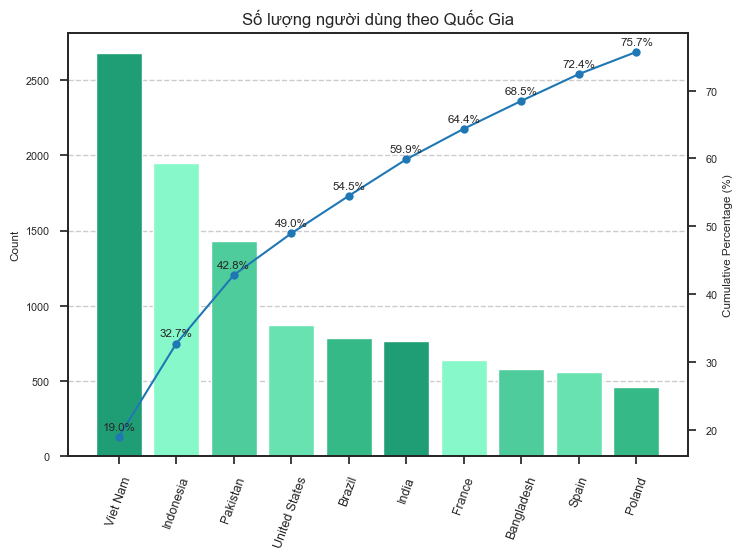

In [55]:

# Sort the data by count in descending order
df = pd.DataFrame(user_overview.groupby('Country')['user_id'].nunique().sort_values(ascending = False)).reset_index()
df = df.rename(columns= {'user_id': 'Count'})

# Calculate cumulative percentage
df['Cumulative Percentage'] = df['Count'].cumsum() / df['Count'].sum() * 100

# Create the Pareto chart
fig, ax1 = plt.subplots()

# Bar plot for the count
ax1.bar(df['Country'].head(10), df['Count'].head(10), color=green_palette)
ax1.set_ylabel('Count')
ax1.tick_params(axis='y')
ax1.tick_params(axis='x', labelsize = 9, rotation = 70)
# Secondary y-axis for cumulative percentage
ax2 = ax1.twinx()
ax2.plot(df['Country'].head(10), df['Cumulative Percentage'].head(10), color='tab:blue', marker='o')
ax2.set_ylabel('Cumulative Percentage (%)')
ax2.tick_params(axis='y')
for i, value in enumerate(df['Cumulative Percentage'].head(10)):
    ax2.annotate(f'{value:.1f}%', (df['Country'].iloc[i], value), textcoords="offset points", xytext=(0,5), ha='center')

# Set x-axis tick labels rotation
plt.xticks(rotation=45)

# Add gridlines
ax1.grid(axis='y', linestyle='--')

# Title and labels
plt.title('Số lượng người dùng theo Quốc Gia', size = 12)
plt.xlabel('Category')

# Display the chart
plt.show()

-> Người dùng của Ví K chủ yếu đến từ các nước đang phát triển của khu vực Nam Á và Đông Nam Á (Vietnam, Indo, Pakistan, Bangladesh), Trong đó riêng ba nước Vietnam, Indo, Pakistan đã chiếm 42.8% lượng người dùng ví

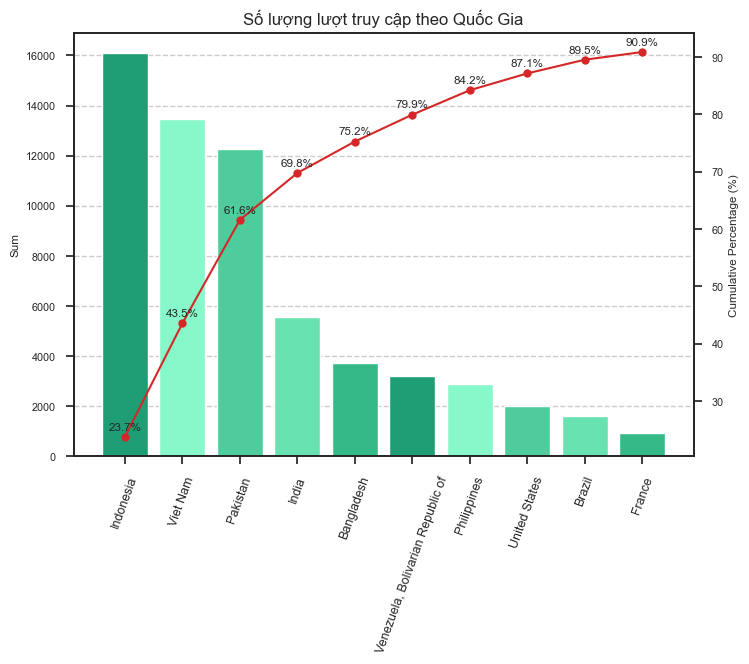

In [56]:

# Sort the data by count in descending order
df = pd.DataFrame(user_overview.groupby('Country')['session'].sum().sort_values(ascending = False)).reset_index()
df = df.rename(columns= {'session': 'Sum'})

# Calculate cumulative percentage
df['Cumulative Percentage'] = df['Sum'].cumsum() / df['Sum'].sum() * 100

# Create the Pareto chart
fig, ax1 = plt.subplots()

# Bar plot for the count
ax1.bar(df['Country'].head(10), df['Sum'].head(10), color=green_palette)
ax1.set_ylabel('Sum')
ax1.tick_params(axis='y')
ax1.tick_params(axis='x', labelsize = 9, rotation = 70)
# Secondary y-axis for cumulative percentage
ax2 = ax1.twinx()
ax2.plot(df['Country'].head(10), df['Cumulative Percentage'].head(10), color='tab:red', marker='o')
ax2.set_ylabel('Cumulative Percentage (%)')
ax2.tick_params(axis='y')
for i, value in enumerate(df['Cumulative Percentage'].head(10)):
    ax2.annotate(f'{value:.1f}%', (df['Country'].iloc[i], value), textcoords="offset points", xytext=(0,5), ha='center')

# Set x-axis tick labels rotation
plt.xticks(rotation=45)

# Add gridlines
ax1.grid(axis='y', linestyle='--')

# Title and labels
plt.title('Số lượng lượt truy cập theo Quốc Gia', size = 12)
plt.xlabel('Category')

# Display the chart
plt.show()

Tương tự như số người dùng, các quốc gia từ Đông Nam Á và Nam Á chiếm phần lớn lượng truy cập của ví K. <br>
Đặc biệt, mặc dù không nằm trong top 10 quốc gia có số lượng người dùng đông nhất, Venezuela lại đứng top 6 về số lượt truy cập

In [57]:
user_overview

user_id platform                  city       os mp_country_code  \
0      15664.0   mobile                  Coro  Windows              VE   
1       5217.0      web             Maracaibo  Windows              VE   
2      12842.0      web             Maracaibo  Windows              VE   
3      24183.0   mobile                  Coro  Windows              VE   
4      27916.0   mobile                  Coro  Windows              VE   
...        ...      ...                   ...      ...             ...   
44649  21153.0   mobile          Point Fortin  Android              TT   
44650  27019.0   mobile  Mariano Roque Alonso  Android              PY   
44651  33335.0   mobile                 Amman  Android              JO   
44652  35900.0   mobile                   NaN  Android              GM   
44653   3286.0   mobile                Bamako  Android              ML   

            time  feature  session  time_per_session  \
0     2023-02-23      2.0      1.0         65.000000   
1     2023-01-31      1.0      1.0         36.000000   
2     2023-01-31      1.0      1.0         50.000000   
3     2023-02-23      5.0      1.0       2057.000000   
4     2023-02-21      9.0      2.0        641.069909   
...          ...      ...      ...               ...   
44649 2023-01-11      4.0      2.0         23.555556   
44650 2023-01-24      7.0      1.0         88.000000   
44651 2023-01-30      3.0      1.0          1.000000   
44652 2023-01-24      2.0      1.0          0.000000   
44653 2023-01-06      2.0      1.0        187.000000   

                                 Country Alpha-2_code Latitude_(average)  \
0      Venezuela, Bolivarian Republic of           VE                  8   
1      Venezuela, Bolivarian Republic of           VE                  8   
2      Venezuela, Bolivarian Republic of           VE                  8   
3      Venezuela, Bolivarian Republic of           VE                  8   
4      Venezuela, Bolivarian Republic of           VE                  8   
...                                  ...          ...                ...   
44649                Trinidad and Tobago           TT                 11   
44650                           Paraguay           PY                -23   
44651                             Jordan           JO                 31   
44652                             Gambia           GM            13.4667   
44653                               Mali           ML                 17   

      Longitude_(average)  
0                     -66  
1                     -66  
2                     -66  
3                     -66  
4                     -66  
...                   ...  
44649                 -61  
44650                 -58  
44651                  36  
44652            -16.5667  
44653                  -4  

[44654 rows x 13 columns]

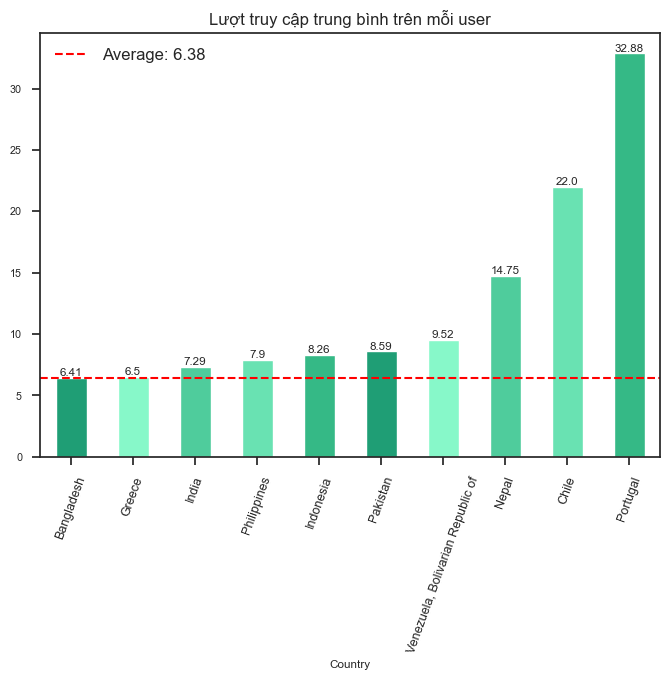

In [58]:
ax = (user_overview.groupby('Country')['session'].sum()/user_overview.groupby('Country')['user_id'].nunique()).sort_values().tail(10).plot.bar(color = green_palette)
for patch in ax.patches:
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_height()
    value = patch.get_height()
    text = f'{round(value,2)}'  # Format the value as desired
    ax.text(x, y, text, ha='center', va='bottom')
average = (user_overview['session'].sum()/user_overview['user_id'].nunique()).mean()
ax.axhline(average, color='red', linestyle='--',  label='Average: {:.2f}'.format(average))
plt.legend(fontsize = 12)
plt.title("Lượt truy cập trung bình trên mỗi user", size = 12)
plt.tick_params(axis='x', labelsize = 9, rotation = 70)
plt.show()

Trong top những quốc gia dẫn đầu về số người dùng hoặc lượt truy cập, Venezuela là nước có số lượt truy cập trung bình trên mỗi user cao nhất với 9.52 lượt

#### Non-transaction users vs transaction users overview

In [59]:
user_overview['is_transact'] = user_overview['user_id'].isin(trans_data['user_id'])
user_overview.head(5)

user_id platform       city       os mp_country_code       time  feature  \
0  15664.0   mobile       Coro  Windows              VE 2023-02-23      2.0   
1   5217.0      web  Maracaibo  Windows              VE 2023-01-31      1.0   
2  12842.0      web  Maracaibo  Windows              VE 2023-01-31      1.0   
3  24183.0   mobile       Coro  Windows              VE 2023-02-23      5.0   
4  27916.0   mobile       Coro  Windows              VE 2023-02-21      9.0   

   session  time_per_session                            Country Alpha-2_code  \
0      1.0         65.000000  Venezuela, Bolivarian Republic of           VE   
1      1.0         36.000000  Venezuela, Bolivarian Republic of           VE   
2      1.0         50.000000  Venezuela, Bolivarian Republic of           VE   
3      1.0       2057.000000  Venezuela, Bolivarian Republic of           VE   
4      2.0        641.069909  Venezuela, Bolivarian Republic of           VE   

  Latitude_(average) Longitude_(average)  is_transact  
0                  8                 -66         True  
1                  8                 -66         True  
2                  8                 -66         True  
3                  8                 -66         True  
4                  8                 -66         True

##### Geographical

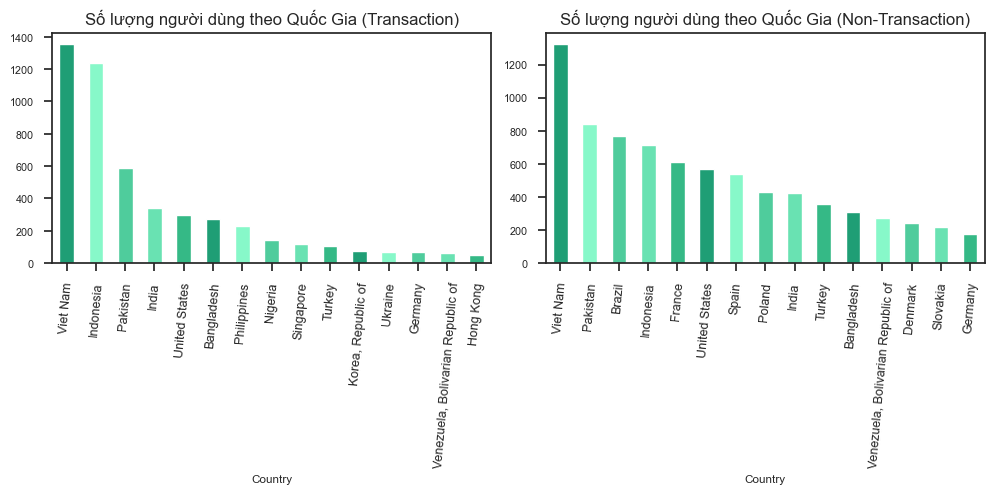

In [60]:
fig, ax = plt.subplots(nrows= 1, ncols= 2, figsize = (10, 5))
user_overview[user_overview['is_transact'] == False].groupby('Country')['user_id'].nunique().sort_values(ascending = False).head(15).plot.bar(ax = ax[0], color = green_palette)
user_overview[user_overview['is_transact'] == True].groupby('Country')['user_id'].nunique().sort_values(ascending = False).head(15).plot.bar(ax = ax[1], color = green_palette)
ax[0].set_title('Số lượng người dùng theo Quốc Gia (Transaction)', size = 12)
ax[1].set_title('Số lượng người dùng theo Quốc Gia (Non-Transaction)', size = 12)
ax[0].tick_params(axis='x', labelsize = 9, rotation = 85)
ax[1].tick_params(axis='x', labelsize = 9, rotation = 85)
plt.tight_layout()
plt.show()

Nhìn chung, sự phân bố người dùng của hai tệp khách hàng transactional và non-transactional không có sự khác biệt quá nhiều, tập trung chủ yếu ở các nước như Việt Nam, Pakistan, Indo, Ấn Độ, Mỹ

##### Behavioural

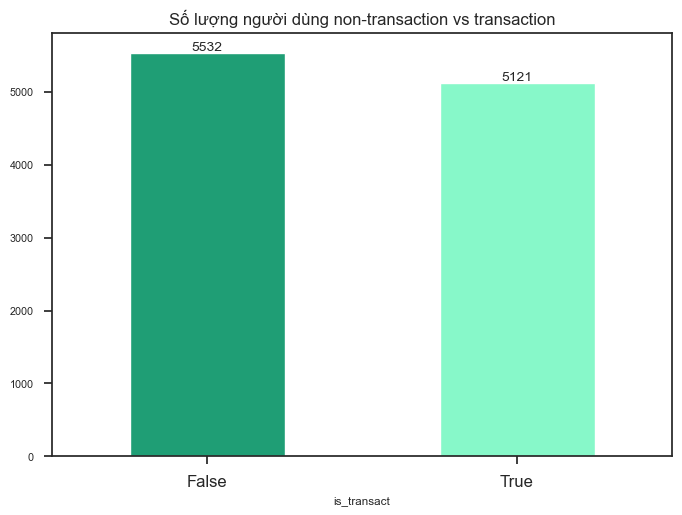

In [61]:
ax = user_overview.groupby('is_transact')['user_id'].nunique().plot.bar(color = green_palette)
for patch in ax.patches:
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_height()
    value = patch.get_height()
    text = f'{round(value,2)}'  # Format the value as desired
    ax.text(x, y, text, ha='center', va='bottom', fontsize = 10)
plt.tick_params(axis = 'x', labelsize = 12, rotation = 0)
plt.title('Số lượng người dùng non-transaction vs transaction', size = 12)
plt.show()

-> Hơn một nửa lượng người dùng của ví K vẫn chưa có giao dịch nào trong hai tháng đầu năm 2023

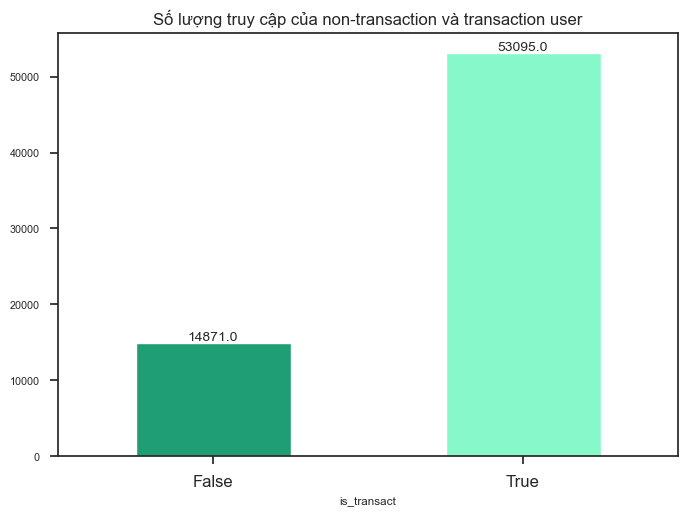

In [62]:
ax = user_overview.groupby('is_transact')['session'].sum().plot.bar(color = green_palette)
for patch in ax.patches:
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_height()
    value = patch.get_height()
    text = f'{round(value,2)}'  # Format the value as desired
    ax.text(x, y, text, ha='center', va='bottom', fontsize = 10)
plt.tick_params(axis = 'x', labelsize = 12, rotation = 0)
plt.title('Số lượng truy cập của non-transaction và transaction user', size = 12)
plt.show()

-> Số lượt truy cập của người có transaction lớn hơn gần 4 lần số lượng truy cập của nhóm không phát sinh giao dịch

In [63]:
user_overview['Total time'] = user_overview['session']*user_overview['time_per_session']

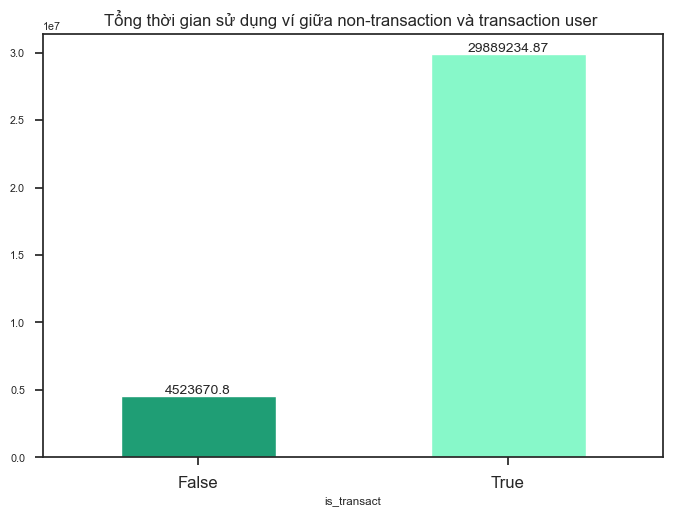

In [64]:
ax = user_overview.groupby('is_transact')['Total time'].sum().plot.bar(color = green_palette)
for patch in ax.patches:
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_height()
    value = patch.get_height()
    text = f'{round(value,2)}'  # Format the value as desired
    ax.text(x, y, text, ha='center', va='bottom', fontsize = 10)
plt.tick_params(axis = 'x', labelsize = 12, rotation = 0)
plt.title('Tổng thời gian sử dụng ví giữa non-transaction và transaction user ', size = 12)
plt.show()

Mặc dù có lượng non-transaction user nhiều hơn transaction user nhưng tổng thời gian sử dụng của nhóm transaction gấp gần 7 nhóm non-transaction

#### New transaction user overview

In [65]:
user_overview_trans = user_overview[user_overview['is_transact'] == True]

In [66]:
user_overview_trans['is_new'] = ~(user_overview_trans['user_id'].isin(user_old[user_old['time'] < '2023'].user_id))

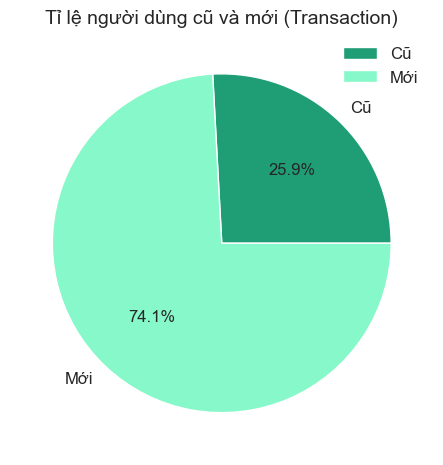

In [67]:
user_overview_trans.groupby('is_new')['user_id'].nunique().plot.pie( autopct='%1.1f%%', textprops = {'fontsize' : 12 }, labels = [ 'Cũ','Mới'], colors = green_palette)
plt.title('Tỉ lệ người dùng cũ và mới (Transaction)', size =14)
plt.legend(fontsize = 12)
plt.ylabel('')
plt.show()

74% người dùng có giao dịch mới chỉ bắt đầu mở tài khoản từ năm 2023

In [68]:
user_overview_non_trans = user_overview[user_overview['is_transact'] == False]

In [69]:
user_overview_non_trans['is_new'] = ~(user_overview_non_trans['user_id'].isin(user_old[user_old['time'] < '2023'].user_id))

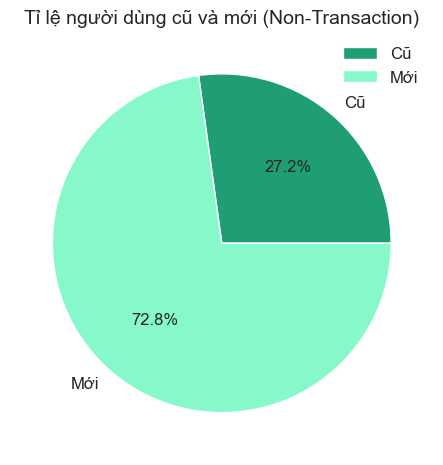

In [70]:
user_overview_non_trans.groupby('is_new')['user_id'].nunique().plot.pie( autopct='%1.1f%%', textprops = {'fontsize' : 12 }, labels = [ 'Cũ','Mới'], colors = green_palette)
plt.title('Tỉ lệ người dùng cũ và mới (Non-Transaction)', size =14)
plt.legend(fontsize = 12)
plt.ylabel('')
plt.show()

Tương tự như nhóm Transaction 73% non-transaction user mới chỉ bắt đầu mở tài khoản từ năm 2023

# 3.Feature Engineering

In [71]:
df = trans_data

In [72]:
# Lay ngay lon nhat trong InvoiceDate + 1
import datetime
current_date = max(df['date']) + datetime.timedelta(days=1)

# -------- Tinh M - MoneytaryValue
df['total_amt'] = df['volume'] + df['fee']

# Group by CustomerID de tinh R, F, M

df_customers = df.groupby(['user_id']).agg(
    {'date': lambda x: (current_date- x.max()).days,
     'user_id':'count',
     'total_amt':'sum'
     }
)

In [73]:
df_customers.rename(columns={'date':'Recency','user_id':'Frequency','total_amt':'MonetaryValue'}, inplace=True)
df_customers

Recency  Frequency  MonetaryValue
user_id                                   
4.0            2        102    4710.457994
23.0           1         35       0.182284
24.0           2         37       0.812294
28.0          41          2      10.123025
31.0           2         13       0.000067
...          ...        ...            ...
30630.0        1         79      28.290691
30644.0       34          1    1038.607788
30645.0       10         10       0.000031
30669.0       15         10       0.000020
30679.0        7          8       5.895342

[5158 rows x 3 columns]

In [74]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 5158 entries, 4.0 to 30679.0
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Recency        5158 non-null   int64  
 1   Frequency      5158 non-null   int64  
 2   MonetaryValue  5158 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 161.2 KB


# 4.EDA

### Recency
Trong vòng hai tháng đầu năm 2023:
* Khoảng thời gian gần nhất ghi nhận có user thực hiện giao dịch trên ví K là vào ngày 28/02/2023.
* Khoảng thời gian xa nhất ghi nhận user lần cuối thực hiện giao dịch là vào 59 ngày trước, là vào ngày 1/1/2023 => Khoảng thời gian này khá lớn, và có hai khả năng xảy ra:
1. Tuy đây là cuối user thực hiện giao dịch trong vòng 2 tháng, tuy nhiên sau đó user lại sử dụng những dịch vụ non-transaction và vẫn là khách hàng của ví K.
2. Đây là lần giao dịch cuối và sau đó không ghi nhận động thái, đồng nghĩa với việc khách hàng này khả năng cao đã churn và không sử dụng ví K nữa => cty có thể sẽ mất thời gian và công sức để thuyết phục những khách hàng này.
* Số lượng các user có lần giao dịch gần nhất rơi vào khoảng 19/02/2023 - 28/02/2023 khá nhiều, chiếm 75.18% lượng user thực hiện giao dịch => Ví K đang được sử dụng bởi đông đảo user.
* Đồng thời, có khoảng tầm 19.3% user có lần thực hiện giao dịch gần nhất là trong tháng 1, đa số nằm ở hai tuần cuối của tháng và sau đó chưa ghi nhận thêm hoạt động giao dịch của những user đó cho đến ngày 28/02/2023 => Công ty cần tập trung vào nhóm KH này, đặc biệt là những KH có lần giao dịch cuối xa ngày 28/02/2023.






In [75]:
df_frequency = df_customers.groupby(['Frequency'])['Frequency'].agg(['count']).rename(columns = {'count':'Count_Frequency'})
df_frequency

Count_Frequency
Frequency                 
1                      915
2                      407
3                      142
4                      135
5                       97
...                    ...
271                      1
273                      1
281                      1
288                      3
294                      1

[232 rows x 1 columns]

In [76]:
# Tính % user có tần suất thực hiệc giao dịch từ 50 lần trở xuống
sub_df = df_frequency.iloc[0:50]
sum(sub_df['Count_Frequency']) / sum(df_frequency['Count_Frequency'])

0.8850329585110508

In [77]:
# Tính % user có tần suất thực hiệc giao dịch từ 10 lần trở xuống
sub_df = df_frequency.iloc[0:10]
sum(sub_df['Count_Frequency']) / sum(df_frequency['Count_Frequency'])

0.46975571927103527

### Frequency
Trong vòng hai tháng đầu năm 2023:
* Trung bình mỗi user sẽ thực hiện 26 giao dịch trong vòng 2 tháng đầu năm 2023.
* Có user giao dịch tới 294 lần trong 2 tháng, trong khi cũng có user chỉ thực hiện giao dịch 1 lần trong 2 tháng.
* Số lượng user thực hiện giao dịch 50 lần trở xuống trong hai tháng chiếm đến 88.5%, đặc biệt là số lượng user thực hiện giao dịch dưới 10 lần chiếm xấp xỉ 47%. Đồng thời, dù tần suất trong tháng trải dài từ 1 - 294 lần, số lượng user có tần suất thực hiện giao dịch trên 50 lần rất ít.
=> Có hai khả năng:
1. Nhóm user có tần suất thực hiện giao dịch dù không nhiều, tức là dùng không nhiều các dịch vụ liên quan đến giao dịch, nhưng lại sử dụng những dịch vụ non-transaction khác thì nhóm user này vẫn là khách hàng của ví K và vẫn hoạt động trên ví K thường xuyên.
2. Nhóm user trên có tần suất thực hiện giao dịch không nhiều và cũng dùng ít các dịch vụ non-transaction khác => khả năng phản hồi với các chiến dịch mới cúa ví K sẽ thấp.

In [78]:
df_customers.Frequency.mean().round()


26.0

In [79]:
df_customers.Frequency.max()

294

In [80]:
df_customers.Frequency.min()

1

Text(0.5, 1.0, '% of users with more than 50 transactions')

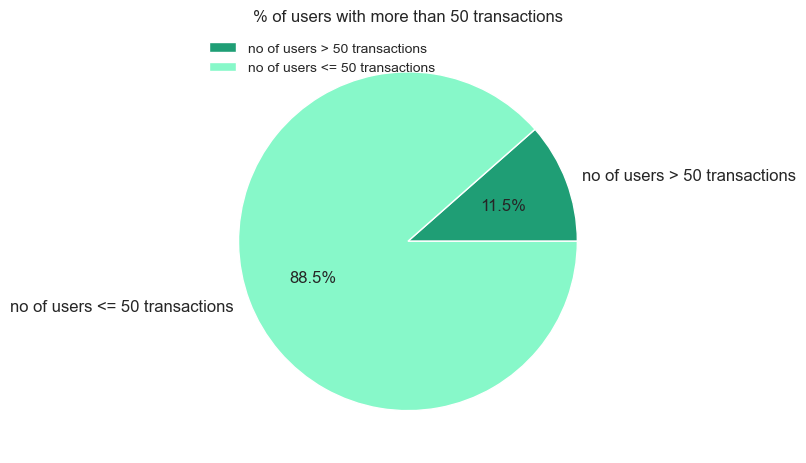

In [81]:
plt.pie(x = [df_customers[df_customers['Frequency']>50].Frequency.count(),df_customers[df_customers['Frequency']<=50].Frequency.count()]
       , labels = ['no of users > 50 transactions', 'no of users <= 50 transactions']
        , autopct='%1.1f%%'
       , textprops = {'fontsize' : 12 }
        , colors = green_palette
       )
plt.legend(fontsize = 10, loc = 'upper left')
plt.title('% of users with more than 50 transactions',size = 12)

### Moneytary Value
Trong vòng hai tháng đầu năm 2023:
* Trung bình, một user sẽ giao dịch một lượng là 644.2863 USD.
* Tổng giá trị giao dịch lớn nhất được ghi nhận là 110524.5 USD (cách biệt đáng kể so với tổng giá trị giao dịch của các user còn lại, user có tổng giao dịch lớn thứ 2 chỉ có 49375.19 USD), trong khi có 2 user có tổng giá trị bé nhất là bằng 0 USD 
* Hơn 77% lượng user có tổng giao dịch dưới 100 USD, và chỉ có khoảng 2% lượng user có tổng giao dịch lớn hơn 10000 USD.

In [82]:
df_customers.MonetaryValue.mean().round()

644.0

In [83]:
round(df_customers.MonetaryValue.max(),2)

110524.54

In [84]:
df_customers[df_customers.MonetaryValue==df_customers.MonetaryValue.min()]

Recency  Frequency  MonetaryValue
user_id                                   
9259.0        35         16            0.0
16702.0       50          2            0.0

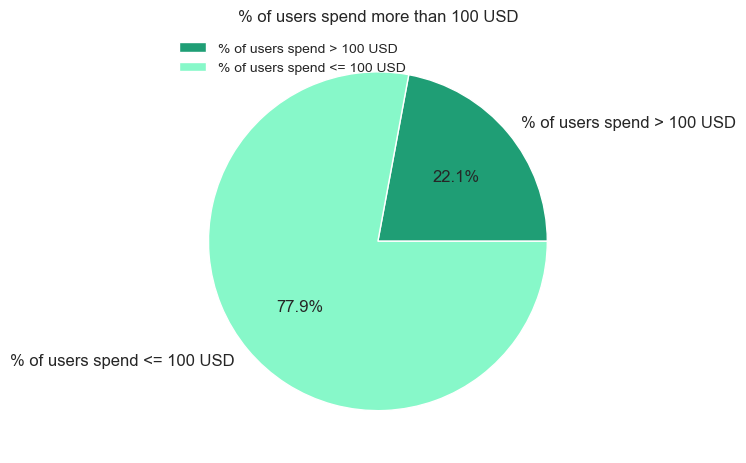

In [85]:
plt.pie(x = [df_customers[df_customers['MonetaryValue']>100].Frequency.count(),df_customers[df_customers['MonetaryValue']<=100].Frequency.count()]
       , labels = ['% of users spend > 100 USD', '% of users spend <= 100 USD']
        , autopct='%1.1f%%'
       , textprops = {'fontsize':12}
        , colors = green_palette
       )
plt.title('% of users spend more than 100 USD',size = 12)
plt.legend(fontsize = 10, loc = 'upper left')
plt.show()

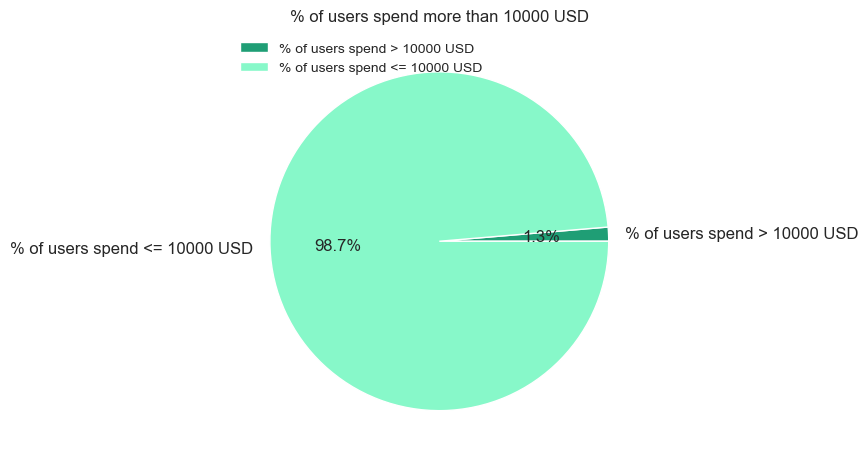

In [86]:
plt.pie(x = [df_customers[df_customers['MonetaryValue']>10000].Frequency.count(),df_customers[df_customers['MonetaryValue']<=10000].Frequency.count()]
       , labels = ['% of users spend > 10000 USD', '% of users spend <= 10000 USD']
        , autopct='%1.1f%%'
       , textprops = {'fontsize':12} 
        , colors = green_palette
       )
plt.legend(fontsize = 10, loc = 'upper left')
plt.title('% of users spend more than 10000 USD', size = 12)
plt.show()

# 5. Xây dựng và đánh giá model

## 5.1 Data preprocessing

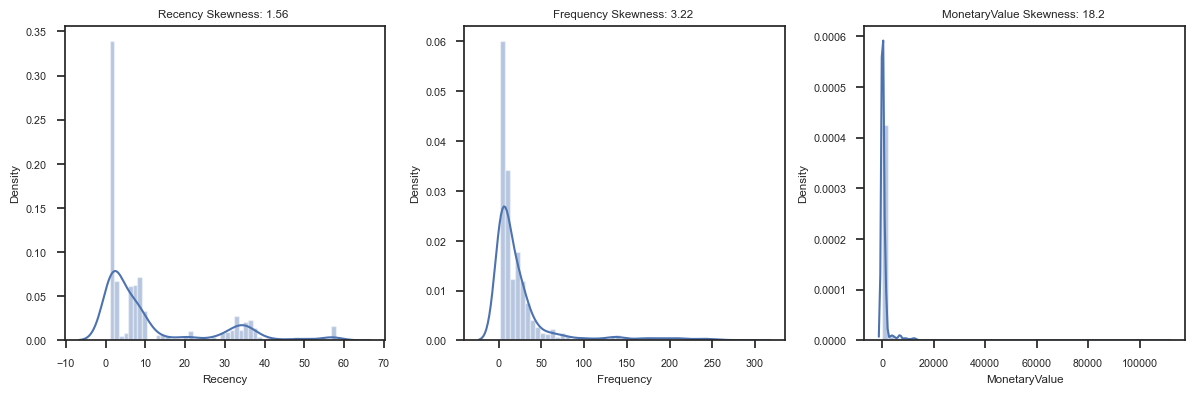

In [87]:
# kiem tra phan phoi

fig, ax = plt.subplots(1, 3, figsize=(12,4))
sns.distplot(df_customers['Recency'], ax = ax[0])
ax[0].set_title(f"Recency Skewness: {(df_customers['Recency'].skew().round(2))} ")
sns.distplot(df_customers['Frequency'], ax = ax[1])
ax[1].set_title(f"Frequency Skewness: {(df_customers['Frequency'].skew().round(2))} ")
sns.distplot(df_customers['MonetaryValue'], ax = ax[2])
ax[2].set_title(f"MonetaryValue Skewness: {(df_customers['MonetaryValue'].skew().round(2))} ")
plt.tight_layout()
plt.show()


-> Phân phối của cả 3 biến đều không đều, chỉ số skewness rất lớn -> Có thể anh hưởng tới hiệu quả của các model phân cụm

In [88]:
# Dua du lieu ve dang phan phoi chuan
def analyze_skewness(x):
    fig, ax = plt.subplots(2, 2, figsize=(7,7))
    
    sns.histplot(df_customers[x], ax=ax[0,0],kde = True)
    ax[0,0].set_title(f"Original skewness: {df_customers[x].skew().round(2)}")
    
    sns.histplot(np.log(df_customers[x]), ax=ax[0,1], kde = True)
    ax[0,1].set_title(f"Skewness after log transformation: {np.log(df_customers[x]).skew().round(2)}")
    
    sns.histplot(np.sqrt(df_customers[x]), ax=ax[1,0], kde = True)
    ax[1,0].set_title(f"Skewness after squareroot transformation: {np.sqrt(df_customers[x]).skew().round(2)}", fontsize = 10)
    
    sns.histplot(stats.boxcox(df_customers[x])[0], ax=ax[1,1], kde = True )
    ax[1,1].set_title(f"Skewness after box-cox transformation : {pd.Series(stats.boxcox(df_customers[x])[0]).skew().round(2)}", fontsize = 10)
    ax[1,1].set_xlabel(x)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Original skewness: {df_customers[x].skew().round(2)}")
    print(f"Skewness after log transformation: {np.log(df_customers[x]).skew().round(2)}")
    print(f"Skewness after squareroot transformation: {np.sqrt(df_customers[x]).skew().round(2)}")
    print(f"Skewness after box-cox transformation : {pd.Series(stats.boxcox(df_customers[x])[0]).skew().round(2)}")
     

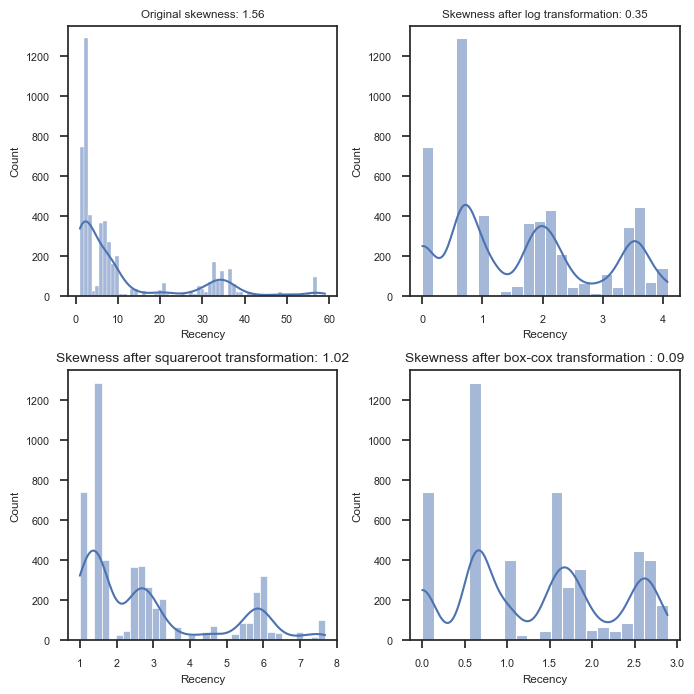

Original skewness: 1.56
Skewness after log transformation: 0.35
Skewness after squareroot transformation: 1.02
Skewness after box-cox transformation : 0.09


In [89]:
analyze_skewness('Recency')

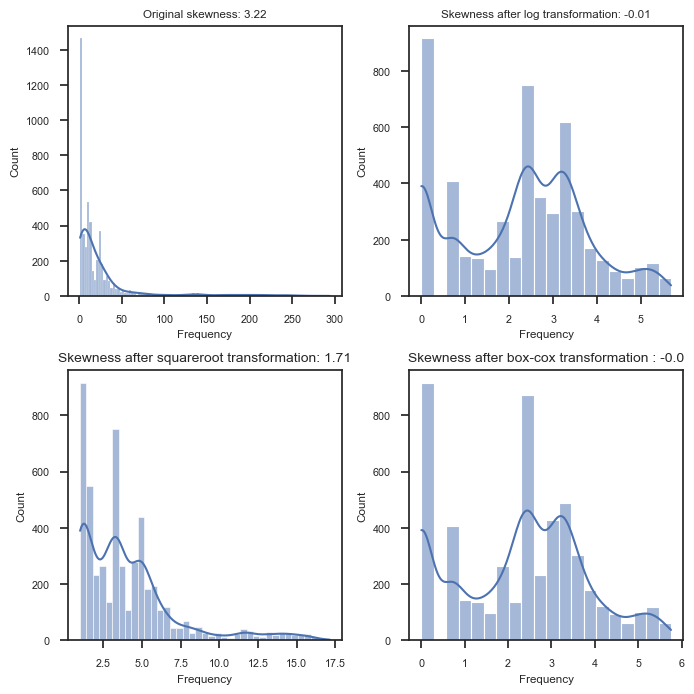

Original skewness: 3.22
Skewness after log transformation: -0.01
Skewness after squareroot transformation: 1.71
Skewness after box-cox transformation : -0.0


In [90]:
analyze_skewness('Frequency')

In [91]:
# cannot use box-cox transformation because there are non-positive value in MonetaryValue
# use 'yeo-johnson' transformation instead
df_customers[['MonetaryValue']].skew()

MonetaryValue    18.199959
dtype: float64

In [92]:
def plots(df, var, t):
    plt.figure(figsize=(13,5))
    plt.subplot(121)
    sns.kdeplot(df[var])
    plt.title('before ' + str(t).split('(')[0] +  ": " + str(df[var].skew().round(2)))
    
    plt.subplot(122)
    p1 = t.fit_transform(df[[var]]).flatten()
    sns.kdeplot(p1)
    plt.title('after ' + str(t).split('(')[0] + ": " + str(pd.DataFrame(t.fit_transform(df[[var]])).skew().loc[0].round(2)))

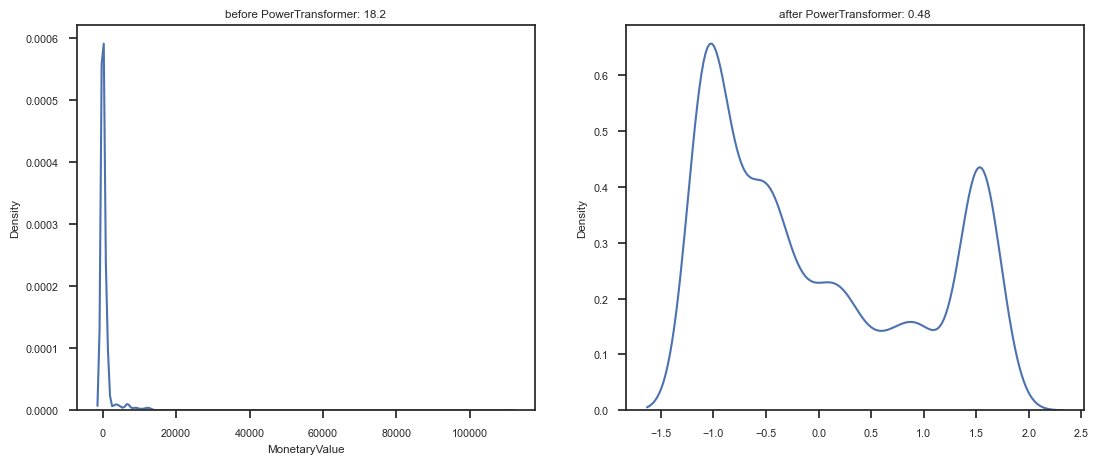

In [93]:
plots(df_customers, 'MonetaryValue', PowerTransformer(method='yeo-johnson'))

In [94]:
df_customers_t = pd.DataFrame(index= df_customers.index)
df_customers_t['Recency'] = stats.boxcox(df_customers['Recency'])[0]
df_customers_t['Frequency'] = stats.boxcox(df_customers['Frequency'])[0]
df_customers_t['MonetaryValue'] = stats.yeojohnson(df_customers['MonetaryValue'])[0]
df_customers_t.head(10)

Recency  Frequency  MonetaryValue
user_id                                    
4.0      0.651608   4.672637       3.110322
23.0     0.000000   3.583470       0.163380
24.0     0.651608   3.639928       0.545369
28.0     2.707454   0.694212       1.724369
31.0     0.651608   2.579565       0.000067
33.0     0.000000   4.165062       0.000186
48.0     1.884654   3.719160       0.000094
49.0     2.707454   0.000000       1.447347
51.0     0.996706   0.694212       2.222061
61.0     0.000000   5.031953       3.139647

In [95]:
scaler = StandardScaler()
scaler.fit(df_customers_t.reset_index(drop= True))

df_customers_t_s = scaler.transform(df_customers_t)

In [96]:
df_customers_t_s

array([[-0.77135577,  1.59284705,  1.63781789],
       [-1.49787653,  0.8709143 , -0.94625655],
       [-0.77135577,  0.90833652, -0.61130358],
       ...,
       [ 0.60344791,  0.0297086 , -1.08949136],
       [ 0.89135832,  0.0297086 , -1.08950183],
       [ 0.33219441, -0.1196391 ,  0.20127035]])

## 5.2 Xây dựng K-mean clustering

### Chọn số K (số cluster)

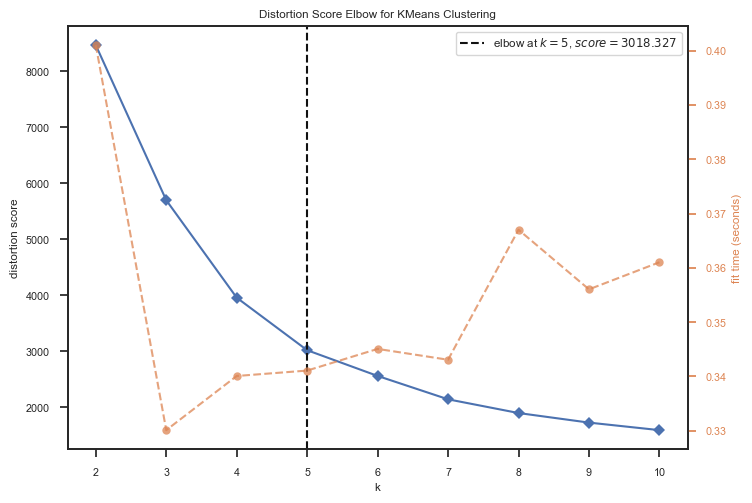

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [97]:
Elbow_M = KElbowVisualizer(KMeans(), k=10, metric='distortion')
Elbow_M.fit(df_customers_t_s)
Elbow_M.show()

Mặc dù điểm distortion giảm nhiều hơn khoảng 4-5, tuy nhiên nhìn từ đồ thị trên thì điểm elbow không được rõ, để chắc chắn hơn nhóm sử dụng thêm điểm silhounette để tìm <b> k phù hợp </b>

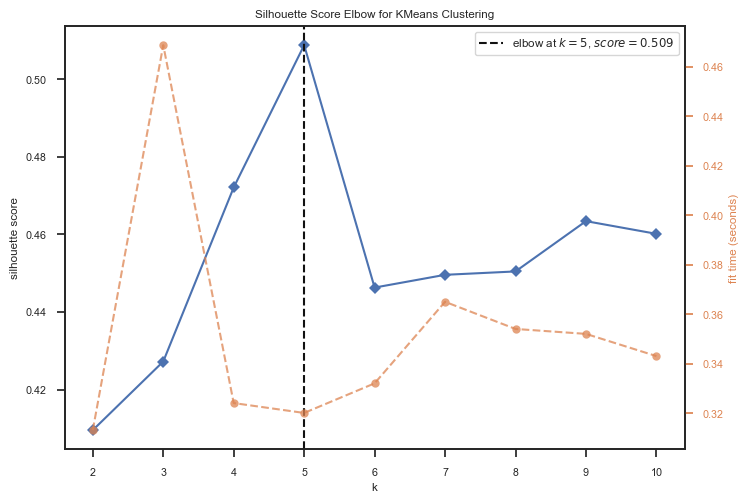

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [98]:
Elbow_M = KElbowVisualizer(KMeans(), k=10, metric='silhouette')
Elbow_M.fit(df_customers_t_s)
Elbow_M.show()

-> Có thể thấy điểm silhouette cũng đạt đỉnh tại k = 5 nên số cluster phù hợp cho dataset này  <b>sẽ là 5 </b > 

### Xây dựng và đánh giá

In [99]:

model = KMeans(n_clusters=5, random_state=203, n_init= 20)
model.fit(df_customers_t_s)

KMeans(n_clusters=5, n_init=20, random_state=203)

In [100]:
df_customers_label = pd.DataFrame(df_customers_t_s, columns= ['Recency', 'Frequency', 'MonetaryValue'])
df_customers_label['Cluster'] = model.fit_predict(df_customers_t_s)


In [101]:
# Calculate Silhouette Coefficient
silhouette_avg = silhouette_score(df_customers_label[['Frequency', 'MonetaryValue', 'Recency']], df_customers_label['Cluster'])

# Print the Silhouette Coefficient
print("Silhouette Coefficient:", silhouette_avg)

Silhouette Coefficient: 0.5088331065475646


In [102]:
df_customers_label

Recency  Frequency  MonetaryValue  Cluster
0    -0.771356   1.592847       1.637818        0
1    -1.497877   0.870914      -0.946257        4
2    -0.771356   0.908337      -0.611304        4
3     1.520841  -1.044174       0.422522        1
4    -0.771356   0.205495      -1.089460        4
...        ...        ...            ...      ...
5153 -1.497877   1.420072       0.785397        0
5154  1.412115  -1.504319       1.500063        1
5155  0.603448   0.029709      -1.089491        2
5156  0.891358   0.029709      -1.089502        2
5157  0.332194  -0.119639       0.201270        3

[5158 rows x 4 columns]

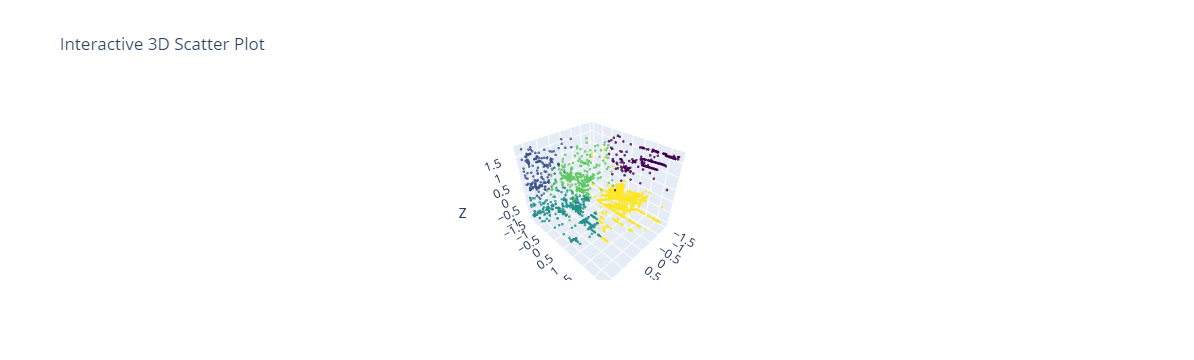

In [103]:
x = df_customers_label['Recency']
y = df_customers_label['Frequency']
z = df_customers_label['MonetaryValue']
scatter = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=1.5,
        color=df_customers_label['Cluster'],
        colorscale='Viridis',
        opacity=0.8
    ),
    
)

# Create the layout
layout = go.Layout(
    title='Interactive 3D Scatter Plot',
    scene=dict(
        xaxis=dict(title='X'),
        yaxis=dict(title='Y'),
        zaxis=dict(title='Z')
    )
)

# Create the figure
fig = go.Figure(data=[scatter], layout=layout)

# Show the interactive plot
fig.show()

Điểm silhouette ở mức 0.51 và nhìn qua đồ thị 3D ta có thể thấy Các cụm được phân bổ rõ ràng theo từng khu vực

In [104]:

df_customers['Cluster'] = model.fit_predict(df_customers_t_s)
df_customers.head()

Recency  Frequency  MonetaryValue  Cluster
user_id                                            
4.0            2        102    4710.457994        0
23.0           1         35       0.182284        4
24.0           2         37       0.812294        4
28.0          41          2      10.123025        1
31.0           2         13       0.000067        4

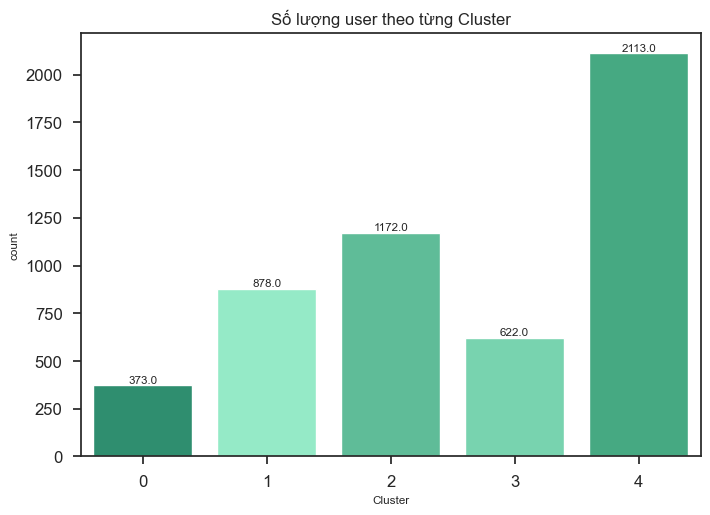

In [105]:
sns.set_palette(green_palette)
ax = sns.countplot(x='Cluster', data=df_customers)

# Access the patches
for patch in ax.patches:
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_height()
    value = patch.get_height()
    text = f'{value}'  # Format the value as desired
    ax.text(x, y, text, ha='center', va='bottom')
ax.set_title('Số lượng user theo từng Cluster', size = 12)
ax.tick_params(labelsize = 12)

Mặc dù các cụm không đucợ phân bố đều về mặt số lượng tuy nhiên khảng cách giữa các cụm không quá lớn và  trong thực tế các tệp khách hàng khác nhau luôn có số lượng khác nhau do các đặc tính về khả năng mua hàng, mục đích mua hàng là khác nhua giữa các nhóm khách hàng

In [170]:
df_customers.reset_index()[['user_id', 'Cluster']].to_excel('cluster.xlsx', index= False )

# 6. Customer profiling

## 6.1 Summary

In [107]:
df_customers.groupby('Cluster').agg(
    {
        'Recency':'mean',
        'Frequency':'mean',
        'MonetaryValue':'mean'
    }
).round(2)
                

Recency  Frequency  MonetaryValue
Cluster                                   
0           1.93     136.87        5962.28
1          31.64       1.24         956.12
2          15.12       6.27           0.36
3          12.45      11.84         411.43
4           2.02      32.02           1.65

In [108]:
#Building RFM segments
r_labels =range(5,0,-1)
f_labels=range(1,6)
m_labels=range(1,6)
r_quartiles = pd.qcut(df_customers['Recency'], q=5, labels = r_labels)
f_quartiles = pd.qcut(df_customers['Frequency'],q=5, labels = f_labels)
m_quartiles = pd.qcut(df_customers['MonetaryValue'],q=5,labels = m_labels)
df_customers = df_customers.assign(R=r_quartiles,F=f_quartiles,M=m_quartiles)

# Build RFM Segment and RFM Score

df_customers['RFM_Score'] = df_customers[['R','F','M']].sum(axis=1)
df_customers.head()

Recency  Frequency  MonetaryValue  Cluster  R  F  M  RFM_Score
user_id                                                                
4.0            2        102    4710.457994        0  5  5  5         15
23.0           1         35       0.182284        4  5  5  2         12
24.0           2         37       0.812294        4  5  5  2         12
28.0          41          2      10.123025        1  1  1  4          6
31.0           2         13       0.000067        4  5  3  1          9

In [109]:
df_customers['R'] = df_customers['R'].astype('int')
df_customers['F'] = df_customers['F'].astype('int')
df_customers['M'] = df_customers['M'].astype('int')

In [110]:
temp = df_customers.groupby('Cluster').agg(
    {
        'R':'mean',
        'F':'mean',
        'M':'mean'
    }
        ).round(2)

In [111]:
temp

R     F     M
Cluster                  
0        4.72  4.90  4.81
1        1.19  1.05  4.71
2        2.25  1.98  1.61
3        2.36  2.76  4.13
4        4.78  3.94  2.40

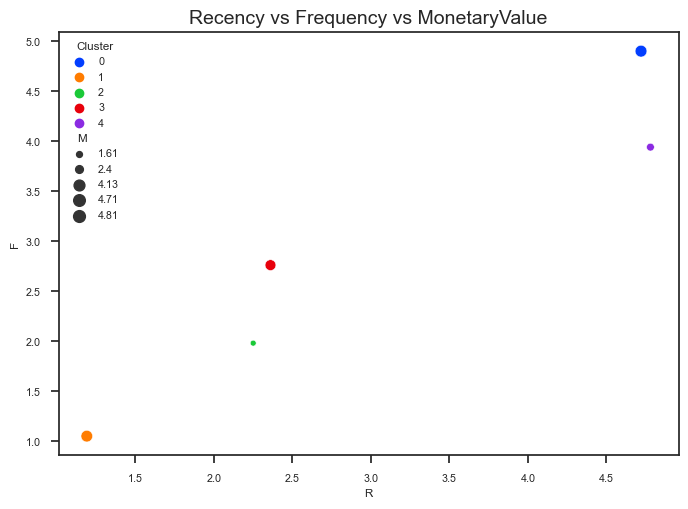

In [112]:
# Display the plot
sns.scatterplot(x=temp['R'], y=temp['F'], size = temp['M'], hue= temp.index, palette= 'bright' )
plt.title("Recency vs Frequency vs MonetaryValue", size = 14)
plt.show()



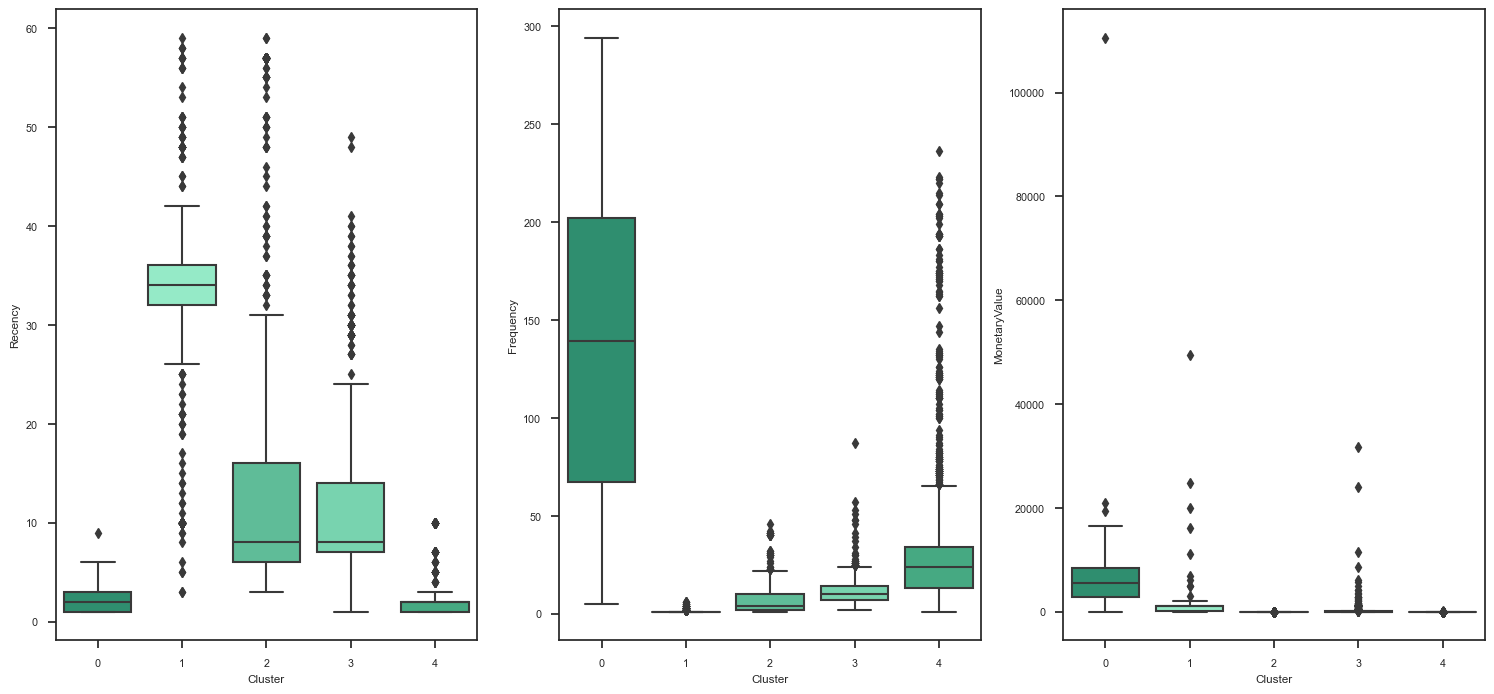

In [113]:
fig, ax = plt.subplots(nrows= 1, ncols= 3, figsize = (15,7))
sns.boxplot(data= df_customers, x = 'Cluster', y = 'Recency',ax =ax[0])
sns.boxplot(data= df_customers, x = 'Cluster', y = 'Frequency',ax =ax[1])
sns.boxplot(data= df_customers, x = 'Cluster', y = 'MonetaryValue',ax =ax[2])

plt.tight_layout()

<b>Cluster 0: </b> MonetaryValue Cao nhất - Frequency Cao nhất - Rececency Thấp <br>
<b>Cluster 1: </b> MonetaryValue Cao - Frequency Thấp nhất - Recency Cao nhất <br>
<b>Cluster 2: </b> MonetaryValue Thấp nhất - Frequency Trung bình - Recency Trung bình <br>
<b>Cluster 3: </b> MonetaryValue Cao - Frequency Trung bình - Recency Trung bình <br>
<b>Cluster 4: </b> MonetaryValue Thấp - Frequency Cao - Recency Thấp nhất <br>

## 6.2 Geography and Platform

#### Đánh dấu Cluster tương ứng cho hai bảng trans và user_info 

##### Bảng user_info

In [114]:
cluster = pd.read_csv('cluster.csv')


In [115]:
user_data_label = pd.merge(left = user_data , right = cluster, on = 'user_id')

In [116]:
user_data_label = pd.merge(left = user_data_label , right = geo, left_on = 'mp_country_code', right_on= 'Alpha-2_code')

In [117]:
user_data_label.drop(labels= ['mp_country_code', 'Alpha-2_code'], axis = 1, inplace= True)

In [118]:
user_data_label.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32100 entries, 0 to 32099
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              32100 non-null  object        
 1   platform             32100 non-null  object        
 2   city                 28862 non-null  object        
 3   os                   32100 non-null  object        
 4   time                 32100 non-null  datetime64[ns]
 5   feature              29802 non-null  float64       
 6   session              29802 non-null  float64       
 7   time_per_session     29802 non-null  float64       
 8   Cluster              32100 non-null  int64         
 9   Country              32100 non-null  object        
 10  Latitude_(average)   32100 non-null  object        
 11  Longitude_(average)  32100 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(7)
memory usage: 3.2+ MB


-> Dữ liệu bị thiếu chủ yếu nằm ở cột city

##### Bảng trans_data

In [119]:
trans_data_label = pd.merge(left = trans_data , right = cluster, on = 'user_id')

Vì có trường hợp một người chuyển giữa các quốc gia khác nhau để giao dịch nên để tránh trường hợp many-to-many thì đội sẽ lấy quốc gia mà người đó nhiều giao dịch nhất là quốc gia của họ

In [120]:
x = pd.DataFrame(user_data_label.groupby(['user_id', 'Country', 'Latitude_(average)', 'Longitude_(average)'])['user_id'].count()).rename(columns= {'user_id':'count'}).reset_index()

user_geo_info = x.groupby('user_id')[['Country', 'count' ,'Latitude_(average)', 'Longitude_(average)']].max()
user_geo_info

Country  count Latitude_(average)  \
user_id                                                                
4.0      Venezuela, Bolivarian Republic of      4                  8   
23.0                             Indonesia      3                 -5   
24.0                              Viet Nam      4                 16   
28.0                              Pakistan     15                 30   
31.0                              Pakistan      2                 30   
...                                    ...    ...                ...   
30630.0                           Viet Nam     36                 16   
30644.0                           Viet Nam      3                 16   
30645.0                           Pakistan      1                 30   
30669.0                           Pakistan      1                 30   
30679.0                         Bangladesh     11                 24   

        Longitude_(average)  
user_id                      
4.0                     -66  
23.0                    120  
24.0                    106  
28.0                     70  
31.0                     70  
...                     ...  
30630.0                 106  
30644.0                 106  
30645.0                  70  
30669.0                  70  
30679.0                  90  

[5121 rows x 4 columns]

In [121]:
user_geo_info.to_csv('user_geo_info.csv')

In [122]:
trans_data_label = pd.merge(left = trans_data_label, right = user_geo_info[['Country','Latitude_(average)', 'Longitude_(average)']], on = 'user_id')

In [123]:
trans_data_label

user_id       date platform      volume       fee   total_amt  Cluster  \
0       5146.0 2023-02-17      ios  205.716994  0.000000  205.716994        3   
1       5146.0 2023-02-04      ios  194.660835  0.000000  194.660835        3   
2       5146.0 2023-01-02      ios  134.081809  0.107265  134.189074        3   
3       5146.0 2023-01-24      ios  244.237261  0.000000  244.237261        3   
4       5146.0 2023-01-18      ios  433.221222  0.346577  433.567799        3   
...        ...        ...      ...         ...       ...         ...      ...   
134365  1482.0 2023-02-09  android    9.358781  0.000000    9.358781        3   
134366  1482.0 2023-02-09      web    9.364253  0.000000    9.364253        3   
134367  1482.0 2023-02-09      web   10.163855  0.000000   10.163855        3   
134368  1482.0 2023-02-09      web    9.356010  0.000000    9.356010        3   
134369  6013.0 2023-02-10      web    0.773538  0.000000    0.773538        2   

              Country Latitude_(average) Longitude_(average)  
0       United States                 38                 -97  
1       United States                 38                 -97  
2       United States                 38                 -97  
3       United States                 38                 -97  
4       United States                 38                 -97  
...               ...                ...                 ...  
134365      Indonesia                 -5                 120  
134366      Indonesia                 -5                 120  
134367      Indonesia                 -5                 120  
134368      Indonesia                 -5                 120  
134369     Bangladesh                 24                  90  

[134370 rows x 10 columns]

### Cluster 0

In [124]:

# Create folium Map object
zoom_level = 4
map_object = folium.Map( zoom_start=zoom_level)

# Add heatmap layers for each country
User_count_by_country= pd.DataFrame(user_data_label[user_data_label['Cluster'] ==0].groupby([ 'Latitude_(average)', 'Longitude_(average)'])['user_id'].nunique().reset_index())
plugins.HeatMap(User_count_by_country).add_to(map_object)
for index, row in User_count_by_country.iterrows():
    folium.CircleMarker(
        location=[row['Latitude_(average)'], row['Longitude_(average)']],
        radius=8,
        tooltip= row['user_id']
    ).add_to(map_object)
# Display the map
map_object

Trong nhóm 0 Venezuela là nước có nhiều người tham gia giao dịch nhất với 224 người

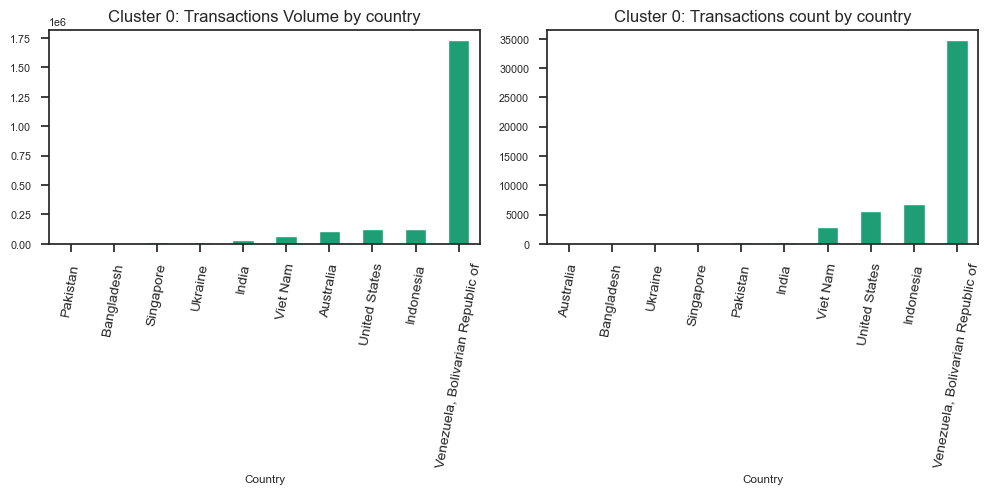

In [125]:
fig, ax =  plt.subplots(nrows= 1, ncols= 2, figsize = (10,5))
trans_data_label[trans_data_label['Cluster']==0].groupby('Country')['volume'].sum().sort_values().sort_values().plot.bar(ax = ax[0])
ax[0].set_title('Cluster 0: Transactions Volume by country',size = 12)
trans_data_label[trans_data_label['Cluster']==0].groupby('Country')['user_id'].count().sort_values().plot.bar(ax = ax[1])
ax[1].set_title('Cluster 0: Transactions count by country', size = 12)
ax[0].tick_params(axis = 'x', labelsize = 10, rotation = 80)
ax[1].tick_params(axis = 'x', labelsize = 10, rotation = 80)
plt.tight_layout()
plt.show()

Ở nhóm 0, Venezuela cũng là nước dẫn đầu về số lượng giao dịch và tổng giá trị lượng giao dịch 

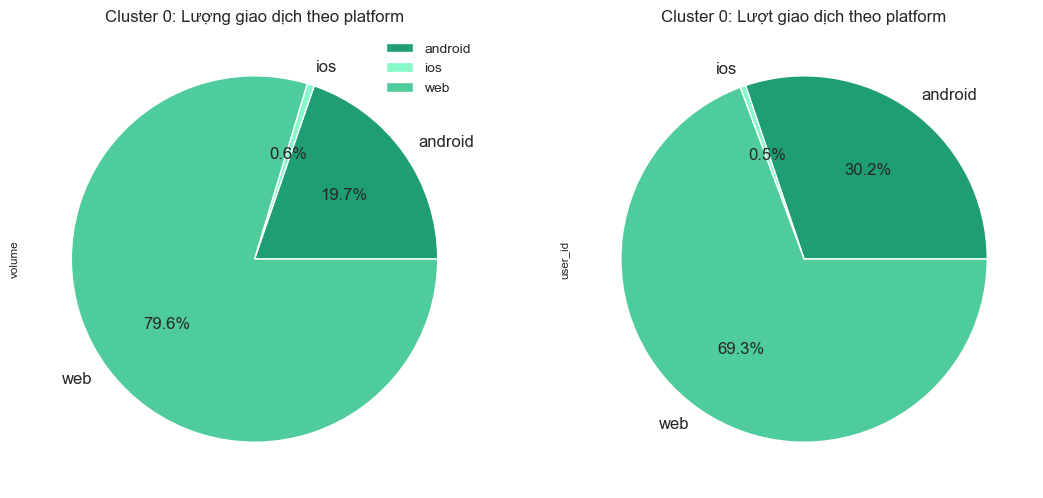

In [126]:
fig , ax = plt.subplots(nrows= 1,  ncols=2, figsize = (13, 6))
trans_data_label[trans_data_label['Cluster'] == 0].groupby('platform')['volume'].sum().plot.pie(autopct = '%1.1f%%', ax = ax[0], textprops = {'fontsize':12})
ax[0].set_title('Cluster 0: Lượng giao dịch theo platform', size =  12)
trans_data_label[trans_data_label['Cluster'] == 0].groupby('platform')['user_id'].count().plot.pie(autopct = '%1.1f%%', ax = ax[1], textprops = {'fontsize':12})
ax[1].set_title('Cluster 0: Lượt giao dịch theo platform', size = 12)
ax[0].legend(loc = 'best', fontsize = 10)



fig.show()

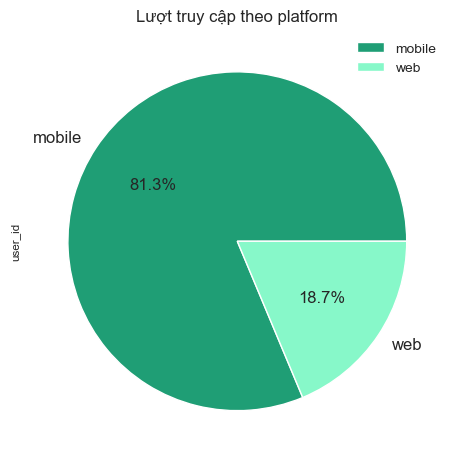

In [127]:
user_data_label[user_data_label['Cluster'] == 0].groupby(by ='platform')['user_id'].count().plot.pie(autopct = "%1.1f%%", textprops = {'fontsize':12})
plt.title("Lượt truy cập theo platform", size =12)
plt.legend(fontsize =10)
plt.show()

-> Mặc dù hầu hết các giao dịch được thực hiện qua web nhưng người dùng ở cluster này vẫn chủ yếu sử dụng các thiết bị di động là phương tiện chủ yếu để truy cập ví

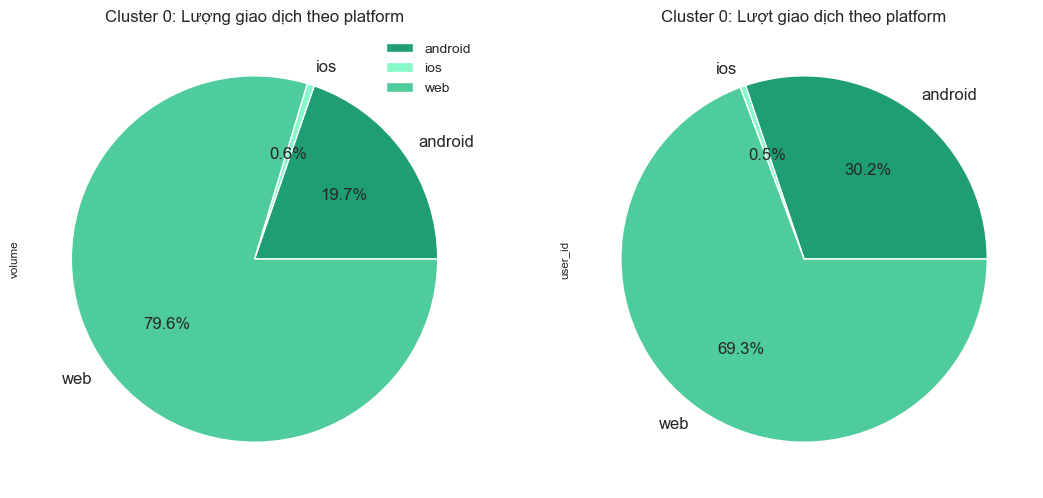

In [128]:
fig , ax = plt.subplots(nrows= 1,  ncols=2, figsize = (13, 6))
trans_data_label[(trans_data_label['Cluster'] == 0)].groupby('platform')['volume'].sum().plot.pie(autopct = '%1.1f%%', ax = ax[0], textprops = {'fontsize':12})
ax[0].set_title('Cluster 0: Lượng giao dịch theo platform', size =  12)
trans_data_label[trans_data_label['Cluster'] == 0].groupby('platform')['user_id'].count().plot.pie(autopct = '%1.1f%%', ax = ax[1], textprops = {'fontsize':12})
ax[1].set_title('Cluster 0: Lượt giao dịch theo platform', size = 12)
ax[0].legend(loc = 'best', fontsize = 10)



fig.show()

### Cluster 1

In [129]:

# Create folium Map object
zoom_level = 5
map_object = folium.Map( zoom_start=zoom_level)

# Add heatmap layers for each country
User_count_by_country= pd.DataFrame(user_data_label[user_data_label['Cluster'] ==1].groupby([ 'Latitude_(average)', 'Longitude_(average)'])['user_id'].nunique().reset_index())
plugins.HeatMap(User_count_by_country).add_to(map_object)
for index, row in User_count_by_country.iterrows():
    folium.CircleMarker(
        location=[row['Latitude_(average)'], row['Longitude_(average)']],
        radius=8,
        tooltip= row['user_id']
    ).add_to(map_object)
# Display the map
map_object

Trong cluster 1 Vietnam là nước có nhiều người tham gia giao dịch nhất với hơn 630 người, Indonesia đứng thứ 2 với 166 người 

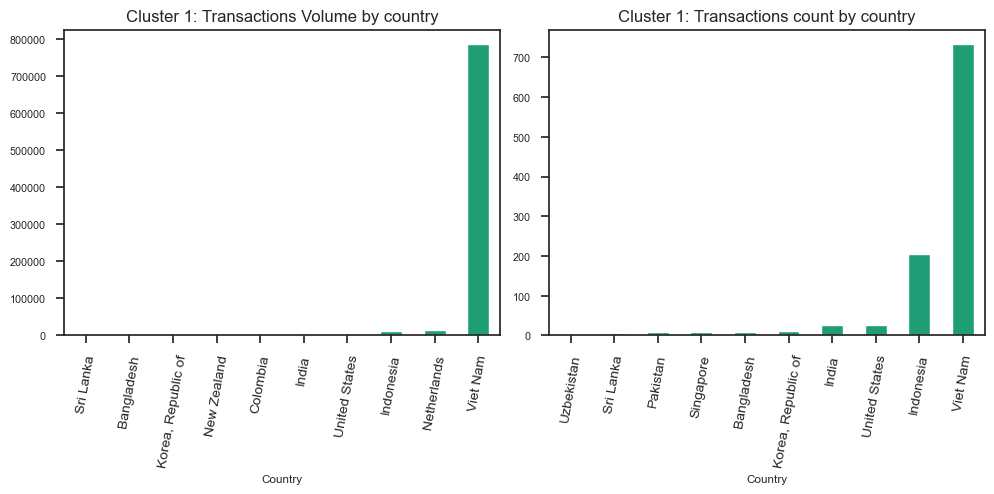

In [130]:
fig, ax =  plt.subplots(nrows= 1, ncols= 2, figsize = (10,5))
trans_data_label[trans_data_label['Cluster']==1].groupby('Country')['volume'].sum().sort_values().tail(10).plot.bar(ax = ax[0])
ax[0].set_title('Cluster 1: Transactions Volume by country', size =12)
trans_data_label[trans_data_label['Cluster']==1].groupby('Country')['user_id'].count().sort_values().tail(10).plot.bar(ax = ax[1])
ax[1].set_title('Cluster 1: Transactions count by country', size  =12)
ax[0].tick_params(axis = 'x', labelsize = 10, rotation = 80)
ax[1].tick_params(axis = 'x', labelsize = 10, rotation = 80)
plt.tight_layout()
plt.show()

Việt Nam cũng là nước dẫn đầu về tổng giá trị giao dịch cũng như số giao dịch được thực hiện

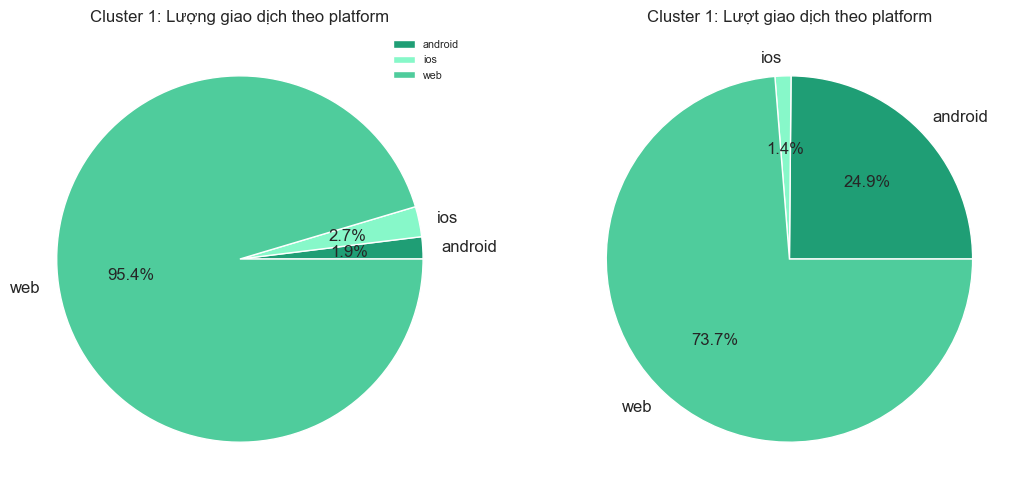

In [131]:
fig , ax = plt.subplots(nrows= 1,  ncols=2, figsize = (13, 6))
trans_data_label[trans_data_label['Cluster'] == 1].groupby('platform')['volume'].sum().plot.pie(autopct = '%1.1f%%', ax = ax[0], textprops = {'fontsize' : 12})
ax[0].set_title('Cluster 1: Lượng giao dịch theo platform', size  = 12)
trans_data_label[trans_data_label['Cluster'] == 1].groupby('platform')['user_id'].count().plot.pie(autopct = '%1.1f%%', ax = ax[1], textprops = {'fontsize' : 12})
ax[1].set_title('Cluster 1: Lượt giao dịch theo platform', size = 12)
ax[0].legend(loc = 'best')
ax[0].set_ylabel('')
ax[1].set_ylabel('')


fig.show()

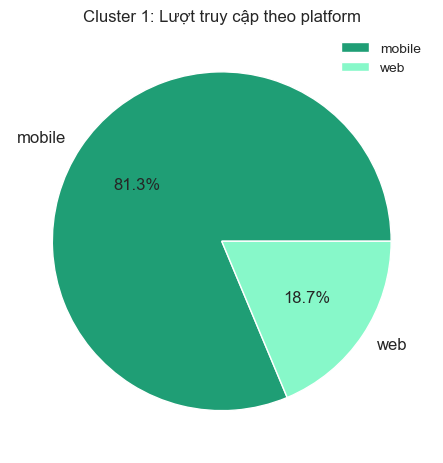

In [132]:
user_data_label[user_data_label['Cluster'] == 0].groupby(by ='platform')['user_id'].count().plot.pie(autopct = "%1.1f%%", textprops = {'fontsize':12})
plt.title("Cluster 1: Lượt truy cập theo platform", size = 12)
plt.legend(fontsize = 10)
plt.ylabel('')
plt.show()

-> Tương tự nhưu nhóm 0, mặc dù hầu hết các giao dịch được thực hiện qua web nhưng người dùng ở cluster này vẫn chủ yếu sử dụng các thiết bị di động là phương tiện chủ yếu để truy cập ví

### Cluster 2

In [133]:

# Create folium Map object
zoom_level = 5
map_object = folium.Map( zoom_start=zoom_level)

# Add heatmap layers for each country
User_count_by_country= pd.DataFrame(user_data_label[user_data_label['Cluster'] ==2].groupby([ 'Latitude_(average)', 'Longitude_(average)'])['user_id'].nunique().reset_index())
plugins.HeatMap(User_count_by_country).add_to(map_object)
for index, row in User_count_by_country.iterrows():
    folium.CircleMarker(
        location=[row['Latitude_(average)'], row['Longitude_(average)']],
        radius=8,
        tooltip= row['user_id']
    ).add_to(map_object)
# Display the map
map_object

Trong cluster 2 người sử dụng ví K đến chủ yếu từ các nước đang phát triển của khu vực Nam á và đông nam á như Ấn độ, Bangladesh, Pakistan, Indonesia và Philippines 

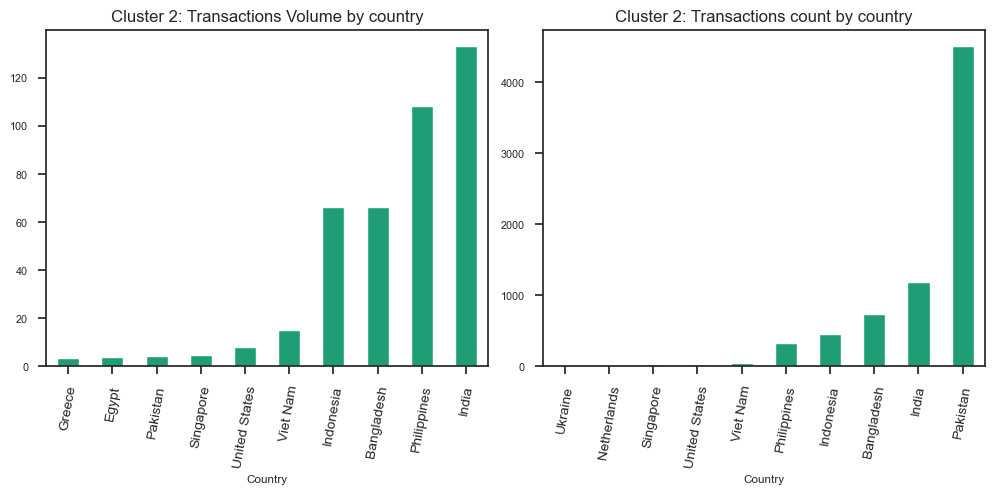

In [134]:
fig, ax =  plt.subplots(nrows= 1, ncols= 2, figsize = (10,5))
trans_data_label[trans_data_label['Cluster']==2].groupby('Country')['volume'].sum().sort_values().tail(10).plot.bar(ax = ax[0])
ax[0].set_title('Cluster 2: Transactions Volume by country', size = 12)
trans_data_label[trans_data_label['Cluster']==2].groupby('Country')['user_id'].count().sort_values().tail(10).plot.bar(ax = ax[1])
ax[1].set_title('Cluster 2: Transactions count by country', size = 12)
ax[0].tick_params(axis = 'x', labelsize = 10, rotation = 80)
ax[1].tick_params(axis = 'x', labelsize = 10, rotation = 80)
plt.tight_layout()
plt.show()

Mặc dù là nước có lượng người dùng cũng như lượt giao dịch lớn nhất, nhưng tổng lượng giao dịch của Pakistan chỉ bằng 1 phần nhỏ so với các nước có số người dùng lớn trong cluster 2 như Indo, Bangladesh, Phillipines, Ấn Độ

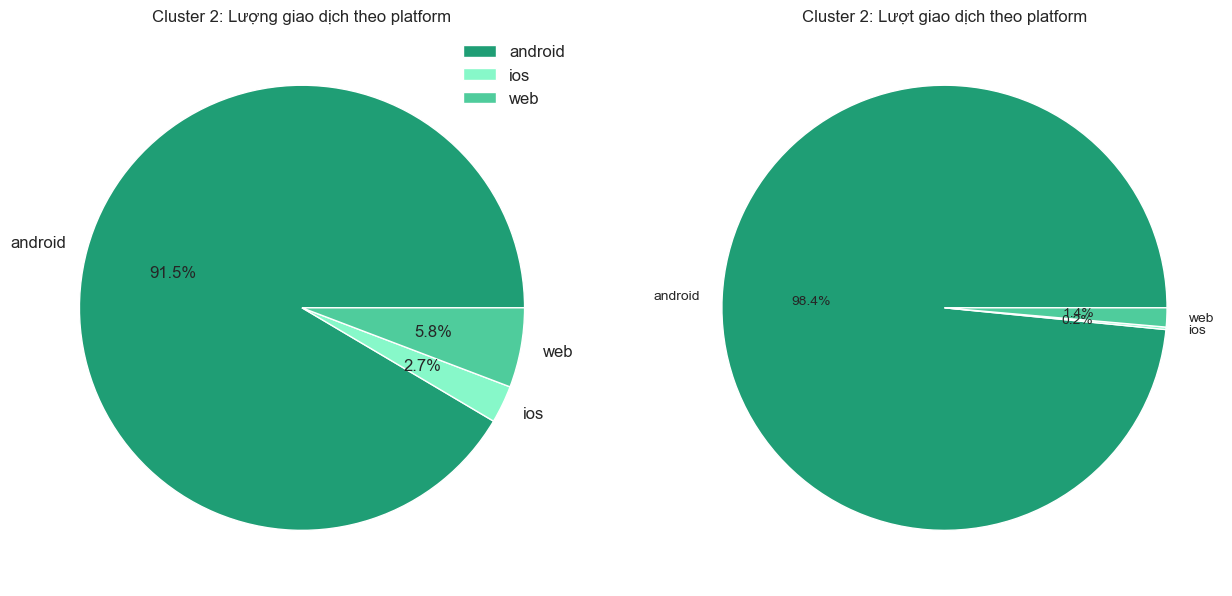

In [135]:
fig , ax = plt.subplots(nrows= 1,  ncols=2, figsize = (13, 6))
trans_data_label[trans_data_label['Cluster'] == 2].groupby('platform')['volume'].sum().plot.pie(autopct = '%1.1f%%', ax = ax[0], textprops = {'fontsize' : 12})
ax[0].set_title('Cluster 2: Lượng giao dịch theo platform', size =12)
ax[0].legend(loc = 'best', fontsize = 12)
ax[0].set_ylabel('')
trans_data_label[trans_data_label['Cluster'] == 2].groupby('platform')['user_id'].count().plot.pie(autopct = '%1.1f%%', ax = ax[1], textprops = {'fontsize' : 10})
ax[1].set_title('Cluster 2: Lượt giao dịch theo platform', size = 12)
ax[1].set_ylabel('')
fig.tight_layout()

fig.show()

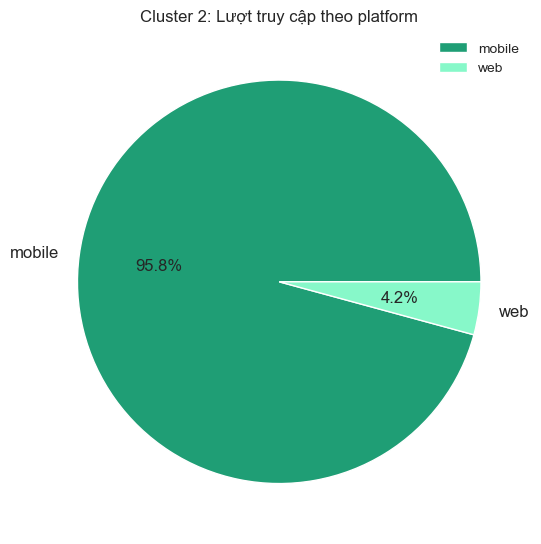

In [136]:
user_data_label[user_data_label['Cluster'] == 2].groupby(by ='platform')['user_id'].count().plot.pie(autopct = "%1.1f%%", textprops = {'fontsize' : 12})
plt.title("Cluster 2: Lượt truy cập theo platform", size = 12)
plt.legend(fontsize = 10)
plt.ylabel('')
plt.tight_layout()
plt.show()

-> Khác với Cluster 0 và 1, nhóm 2 sử dụng các phương tiện di động để truy cập vào ví cũng như để giao dịch trên ví

### Cluster 3

In [137]:

# Create folium Map object
zoom_level = 5
map_object = folium.Map( zoom_start=zoom_level)

# Add heatmap layers for each country
User_count_by_country= pd.DataFrame(user_data_label[user_data_label['Cluster'] ==3].groupby([ 'Latitude_(average)', 'Longitude_(average)'])['user_id'].nunique().reset_index())
plugins.HeatMap(User_count_by_country).add_to(map_object)
for index, row in User_count_by_country.iterrows():
    folium.CircleMarker(
        location=[row['Latitude_(average)'], row['Longitude_(average)']],
        radius=8,
        tooltip= row['user_id']
    ).add_to(map_object)
# Display the map
map_object

Các users ở nhóm 3 phân bổ chủ yếu ở các nước Nam Á và Đông Nam Á (Indo, Ấn Độ, Bangladesh) giống như nhóm 2 và thêm một phần đến từ Venezuela 

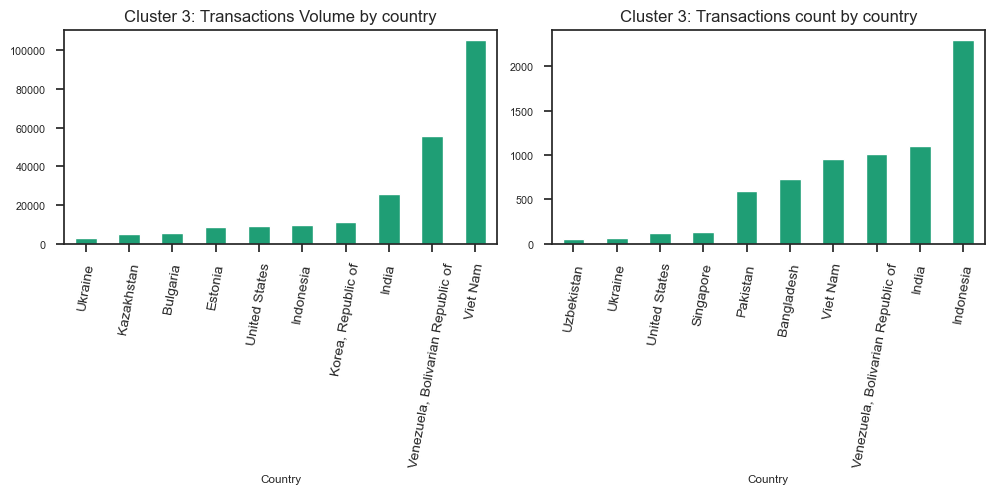

In [138]:
fig, ax =  plt.subplots(nrows= 1, ncols= 2, figsize = (10,5))
trans_data_label[trans_data_label['Cluster']==3].groupby('Country')['volume'].sum().sort_values().tail(10).plot.bar(ax = ax[0])
ax[0].set_title('Cluster 3: Transactions Volume by country', size = 12)
trans_data_label[trans_data_label['Cluster']==3].groupby('Country')['user_id'].count().sort_values().tail(10).plot.bar(ax = ax[1])
ax[1].set_title('Cluster 3: Transactions count by country', size =12 )
ax[0].tick_params(axis = 'x', labelsize = 10, rotation = 80)
ax[1].tick_params(axis = 'x', labelsize = 10, rotation = 80)
plt.tight_layout()
plt.show()

Các nước Đông nam á và Nam Á cũng chiếm tỉ trọng cao trong số lượng giao dịch cũng như giá trị giao dịch

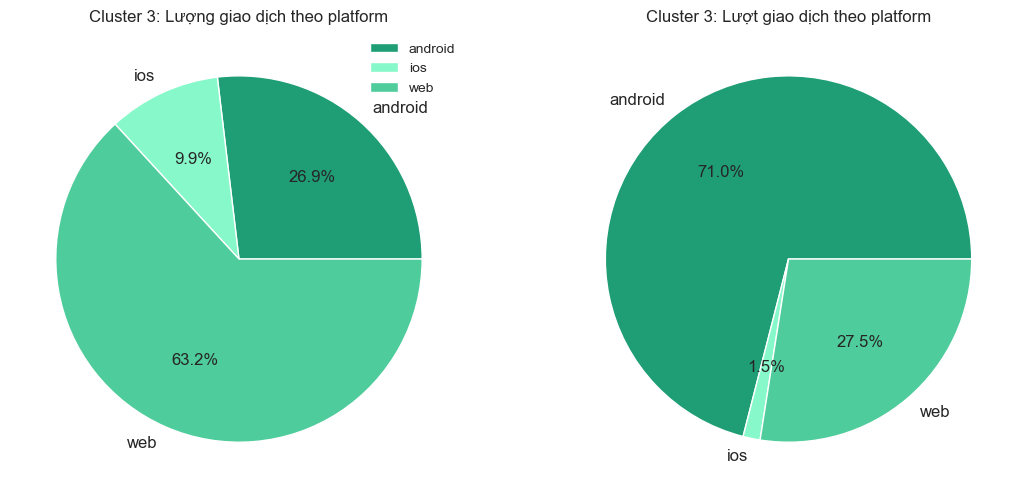

In [139]:
fig , ax = plt.subplots(nrows= 1,  ncols=2, figsize = (13, 6))
trans_data_label[trans_data_label['Cluster'] == 3].groupby('platform')['volume'].sum().plot.pie(autopct = '%1.1f%%', ax = ax[0], textprops = {'fontsize' : 12 })
ax[0].set_title('Cluster 3: Lượng giao dịch theo platform', size = 12)
ax[0].legend(loc = 'best', fontsize = 10)
ax[0].set_ylabel('')
trans_data_label[trans_data_label['Cluster'] == 3].groupby('platform')['user_id'].count().plot.pie(autopct = '%1.1f%%', ax = ax[1], textprops = {'fontsize' : 12 })
ax[1].set_title('Cluster 3: Lượt giao dịch theo platform', size = 12)
ax[1].set_ylabel('')


fig.show()

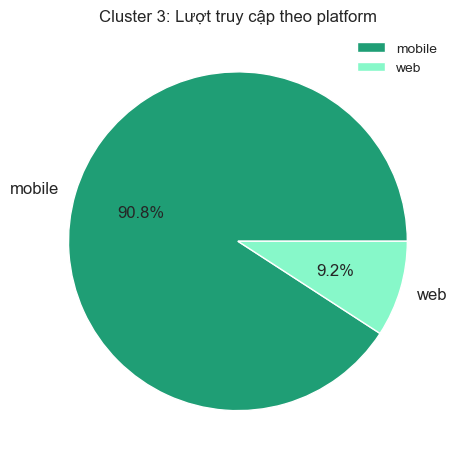

In [140]:
user_data_label[user_data_label['Cluster'] == 3].groupby(by ='platform')['user_id'].count().plot.pie(autopct = "%1.1f%%", textprops = {'fontsize' : 12 })
plt.title("Cluster 3: Lượt truy cập theo platform", size = 12)
plt.legend(fontsize = 10)
plt.ylabel('')
plt.show()


Mặc dù số lượng giao dịch <b> phần lớn </b>  được thực hiện qua các thiết bị di động nhưng <b> giá trị giao dịch </b> khi được thực hiên trên web lại cao hơn đáng kể khi thức hiện qua các nền tảng di động

### Cluster 4

In [141]:

# Create folium Map object
zoom_level = 5
map_object = folium.Map( zoom_start=zoom_level)

# Add heatmap layers for each country
User_count_by_country= pd.DataFrame(user_data_label[user_data_label['Cluster'] ==4].groupby([ 'Latitude_(average)', 'Longitude_(average)'])['user_id'].nunique().reset_index())
plugins.HeatMap(User_count_by_country).add_to(map_object)
for index, row in User_count_by_country.iterrows():
    folium.CircleMarker(
        location=[row['Latitude_(average)'], row['Longitude_(average)']],
        radius=8,
        tooltip= row['user_id']
    ).add_to(map_object)
# Display the map
map_object

Các users ở cluster 4 phân bố khá đồng đều ở các châu lục trên thế giới

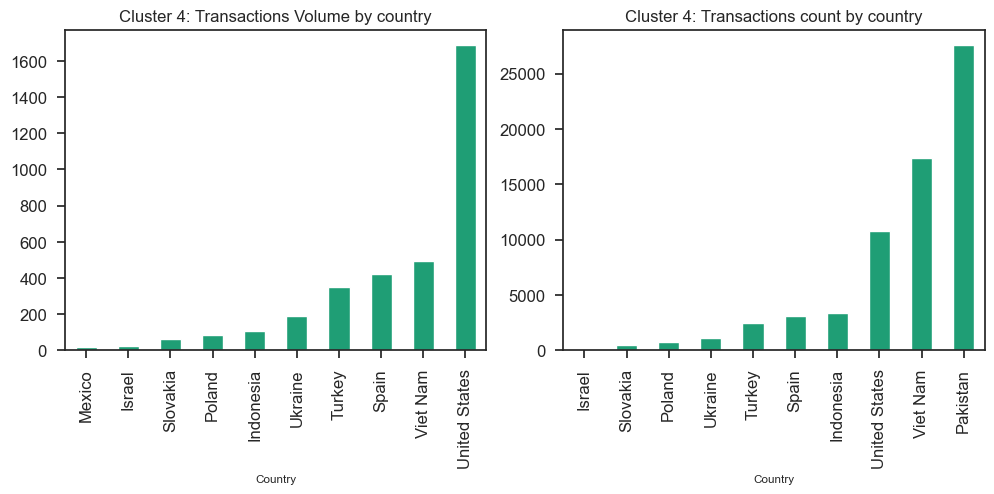

In [142]:
fig, ax =  plt.subplots(nrows= 1, ncols= 2, figsize = (10,5))
trans_data_label[trans_data_label['Cluster']==4].groupby('Country')['volume'].sum().sort_values().tail(10).plot.bar(ax = ax[0])
ax[0].set_title('Cluster 4: Transactions Volume by country', size =12)
ax[0].tick_params(labelsize = 12)
trans_data_label[trans_data_label['Cluster']==4].groupby('Country')['user_id'].count().sort_values().tail(10).plot.bar(ax = ax[1])
ax[1].set_title('Cluster 4: Transactions count by country', size = 12)
ax[1].tick_params(labelsize = 12)
plt.tight_layout()
plt.show()

-> Mặc dù khu vực Nam Á và Đông Nam Á có lượng giao dịch nhiều hơn, Mỹ là nước có tổng lượng giao dịch lớn nhất

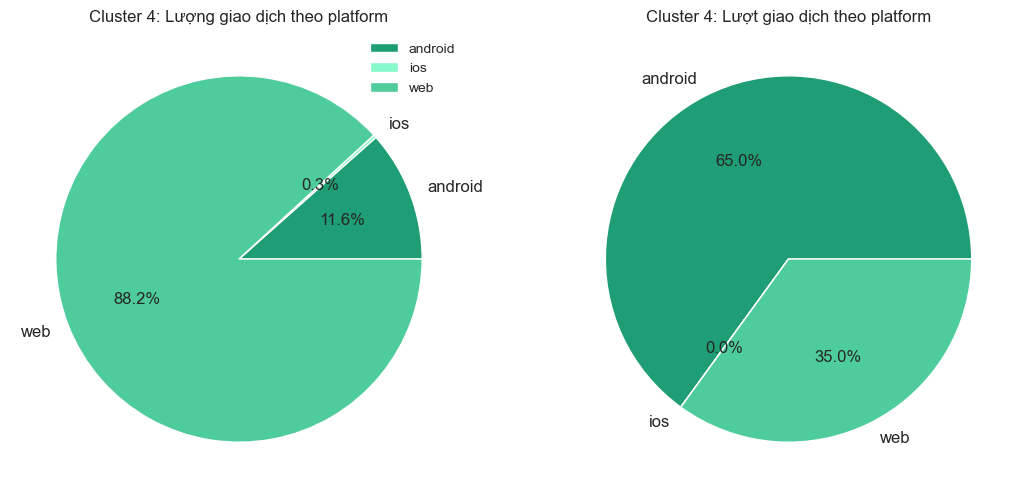

In [143]:
fig , ax = plt.subplots(nrows= 1,  ncols=2, figsize = (13, 6))
trans_data_label[trans_data_label['Cluster'] == 4].groupby('platform')['volume'].sum().plot.pie(autopct = '%1.1f%%', ax = ax[0],textprops={'fontsize': 12})
ax[0].set_title('Cluster 4: Lượng giao dịch theo platform', size = 12)
ax[0].legend(loc = 'best', fontsize = 10)
ax[0].set_ylabel('')
trans_data_label[trans_data_label['Cluster'] == 4].groupby('platform')['user_id'].count().plot.pie(autopct = '%1.1f%%', ax = ax[1],textprops={'fontsize': 12})
ax[1].set_title('Cluster 4: Lượt giao dịch theo platform', size = 12)
ax[1].set_ylabel('')


fig.show()

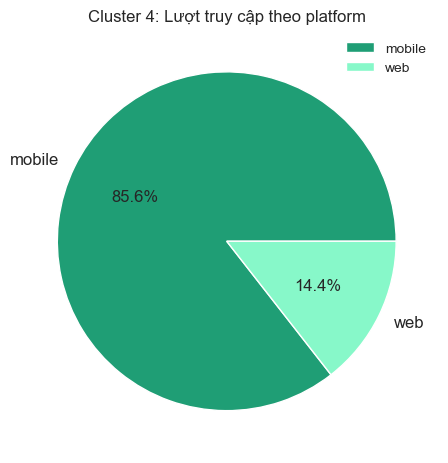

In [144]:
user_data_label[user_data_label['Cluster'] == 4].groupby(by ='platform')['user_id'].count().plot.pie(autopct = "%1.1f%%", textprops={'fontsize': 12})
plt.title("Cluster 4: Lượt truy cập theo platform", size = 12)
plt.legend(fontsize = 10)
plt.ylabel('')
plt.show()


Tương tự như cluster 4: Mặc dù số lượng giao dịch trong cluster 4 phần lớn được thực hiện qua các thiết bị di động nhưng giá trị giao dịch khi được thực hiên trên web lại cao hơn đáng kể khi thức hiện qua các nền tảng di động

## 6.3 Transactions behavior

##### Transaction/user (mỗi user có bao nhiêu transactions)

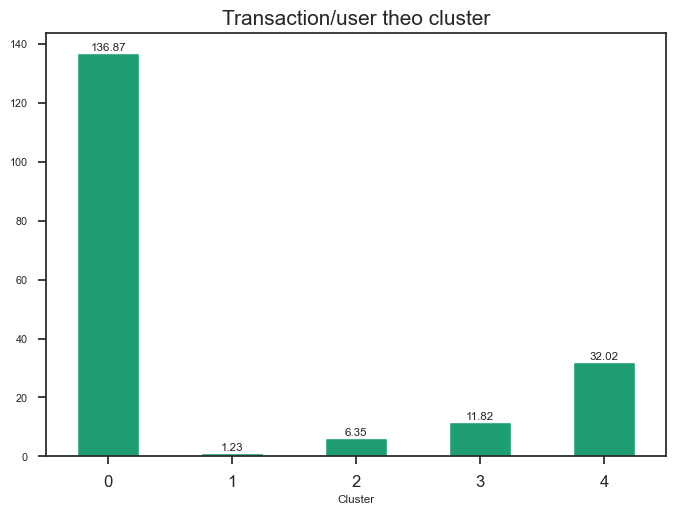

In [145]:
ax = (trans_data_label.groupby('Cluster')['user_id'].count()/trans_data_label.groupby('Cluster')['user_id'].nunique()).plot.bar()
for patch in ax.patches:
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_height()
    value = patch.get_height()
    text = f'{round(value,2)}'  # Format the value as desired
    ax.text(x, y, text, ha='center', va='bottom')
ax.tick_params(axis='x', rotation=0, labelsize = 12)
ax.set_title('Transaction/user theo cluster', fontdict={'fontsize' : 15})
plt.show()

Trong hai tháng đầu năm của năm 2023, mỗi user trong Cluster 0 có số lượt giao dịch lớn hơn hẳn các nhóm khác 

##### Tần suất giao dịch theo ngày

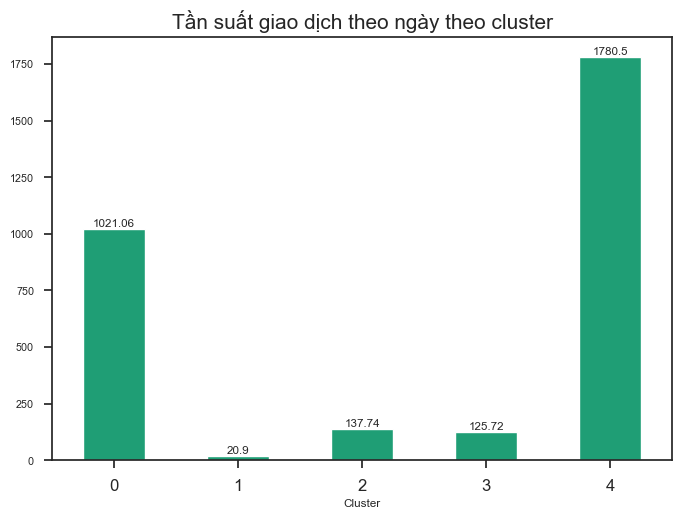

In [146]:
ax = (trans_data_label.groupby('Cluster')['user_id'].count()/trans_data_label.groupby('Cluster')['date'].nunique()).plot.bar()
for patch in ax.patches:
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_height()
    value = patch.get_height()
    text = f'{round(value,2)}'  # Format the value as desired
    ax.text(x, y, text, ha='center', va='bottom')
ax.tick_params(axis='x', rotation=0, labelsize = 12)
ax.set_title('Tần suất giao dịch theo ngày theo cluster', fontdict={'fontsize' : 15})
plt.show()

-> Nhóm 4 có tần suất giao dịch cao hơn các nhóm khác rất nhiều trung bình một ngày có hơn 1700 giao dịch

-> Trung bình 1 ngày nhóm 1 chỉ có hơn 20 giao dịch, thấp nhất trong tất cả các nhóm

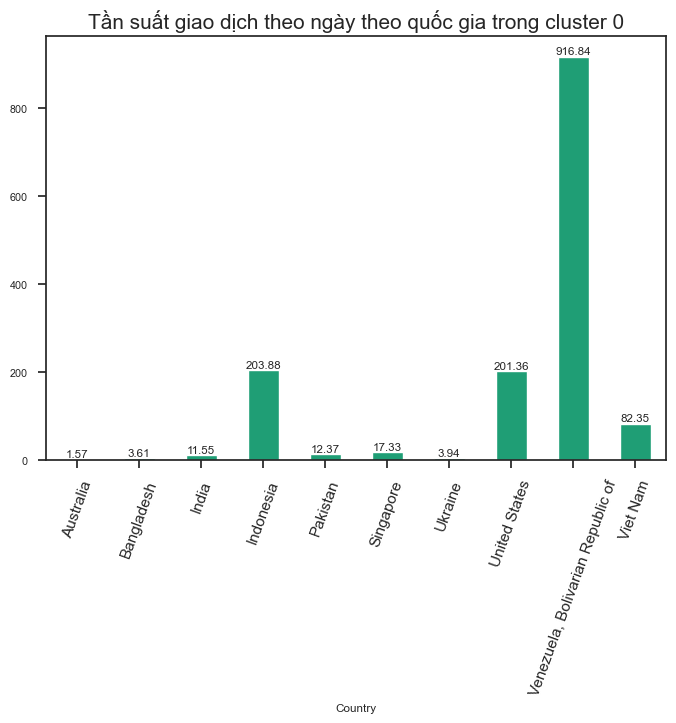

In [147]:
ax = (trans_data_label[trans_data_label['Cluster'] == 0].groupby('Country')['user_id'].count()/trans_data_label[trans_data_label['Cluster'] == 0].groupby('Country')['date'].nunique()).plot.bar()
for patch in ax.patches:
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_height()
    value = patch.get_height()
    text = f'{round(value,2)}'  # Format the value as desired
    ax.text(x, y, text, ha='center', va='bottom')
ax.tick_params(axis='x', rotation=70, labelsize = 11)
ax.set_title('Tần suất giao dịch theo ngày theo quốc gia trong cluster 0', fontdict={'fontsize' : 15})
plt.show()

Trong cluster 0 mỗi người người dùng ở Venezuela có lượt giao dịch lớn hơn rất nhiều các nước còn lại trong cùng cluster

##### Trung bình tổng giá trị giao dịch của một người

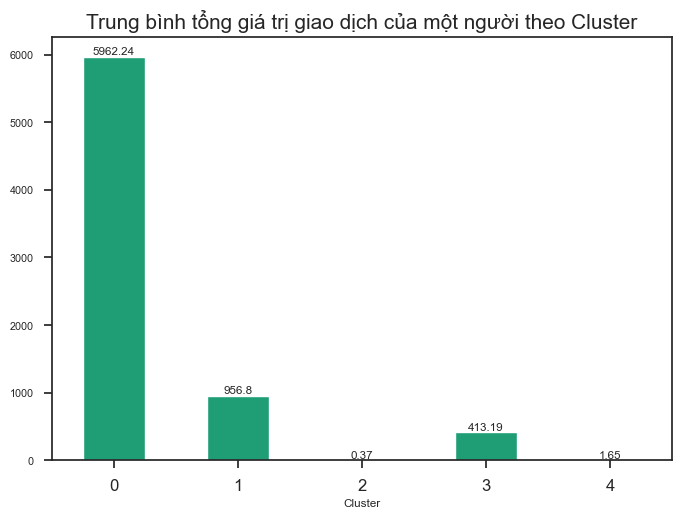

In [148]:
ax = (trans_data_label.groupby('Cluster')['volume'].sum()/trans_data_label.groupby('Cluster')['user_id'].nunique()).plot.bar()
for patch in ax.patches:
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_height()
    value = patch.get_height()
    text = f'{round(value,2)}'  # Format the value as desired
    ax.text(x, y, text, ha='center', va='bottom')
ax.tick_params(axis='x', rotation=0, labelsize = 12)
ax.set_title('Trung bình tổng giá trị giao dịch của một người theo Cluster', fontdict={'fontsize' : 15})
plt.show()

-> Trung bình một người trong cluster 0 tiêu nhiều tiền hơn những cluster khác khá nhiều

##### Giá trị trên mỗi giao dịch

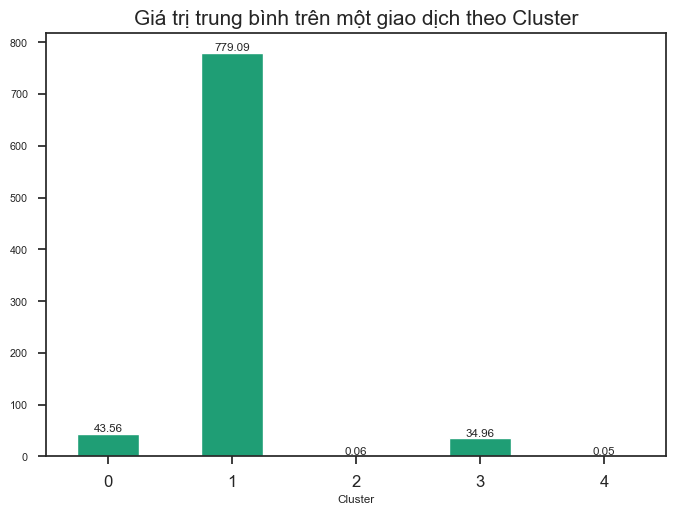

In [149]:
ax = (trans_data_label.groupby('Cluster')['volume'].sum()/trans_data_label.groupby('Cluster')['user_id'].count()).plot.bar()
for patch in ax.patches:
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_height()
    value = patch.get_height()
    text = f'{round(value,2)}'  # Format the value as desired
    ax.text(x, y, text, ha='center', va='bottom')
ax.tick_params(axis='x', rotation=0, labelsize = 12)
ax.set_title('Giá trị trung bình trên một giao dịch theo Cluster', fontdict={'fontsize' : 15})
plt.show()

-> Giá trị trung bình mỗi giao dịch của nhóm 1 vượt trội so với những nhóm khác

-> Nhóm 2 và 4 có giá trị trung bình mỗi giao dịch rất nhỏ, ở dưới mức 0.1 $

##### Lượng giao dịch theo ngày trong tuần

###### Nhóm 0

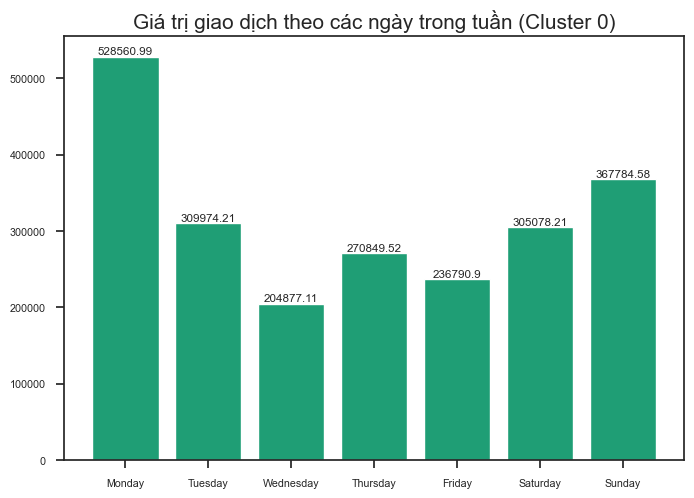

In [150]:
trans_data_label['weekdaynum']= trans_data_label['date'].dt.isocalendar().week
trans_data_label['weekday']= trans_data_label['date'].dt.strftime('%A')
grouped_data = trans_data_label[trans_data_label['Cluster'] == 0].groupby('weekday')['volume'].sum()
grouped_data = pd.DataFrame(grouped_data).reset_index()
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
grouped_data['weekday'] = pd.Categorical(grouped_data['weekday'], categories=cats, ordered=True)
plt.bar(data = grouped_data.sort_values(by= 'weekday'), x = 'weekday', height = 'volume')
for i, value in enumerate(grouped_data.sort_values(by= 'weekday')['volume']):
    plt.text(i, value, str(round(value,2)), ha='center', va='bottom')
plt.title('Giá trị giao dịch theo các ngày trong tuần (Cluster 0)', fontdict={'fontsize': 15})
plt.show()

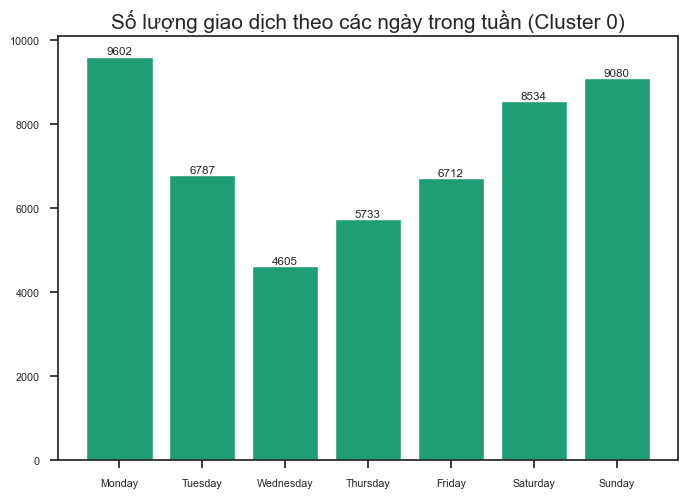

In [151]:
grouped_data = trans_data_label[trans_data_label['Cluster'] == 0].groupby('weekday')['user_id'].count()
grouped_data = pd.DataFrame(grouped_data).reset_index()
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
grouped_data['weekday'] = pd.Categorical(grouped_data['weekday'], categories=cats, ordered=True)
plt.bar(data = grouped_data.sort_values(by= 'weekday'), x = 'weekday', height = 'user_id')
for i, value in enumerate(grouped_data.sort_values(by= 'weekday')['user_id']):
    plt.text(i, value, str(round(value,2)), ha='center', va='bottom')
plt.title('Số lượng giao dịch theo các ngày trong tuần (Cluster 0)', fontdict={'fontsize': 15})
plt.show()

-> Trong nhóm 0, giá trị giao dịch và số giao dịch có xu hướng giảm vào giữa tuần nhưng nhìn chung không có sự khác biệt lớn giữa các ngày trong tuần 

###### Nhóm 1

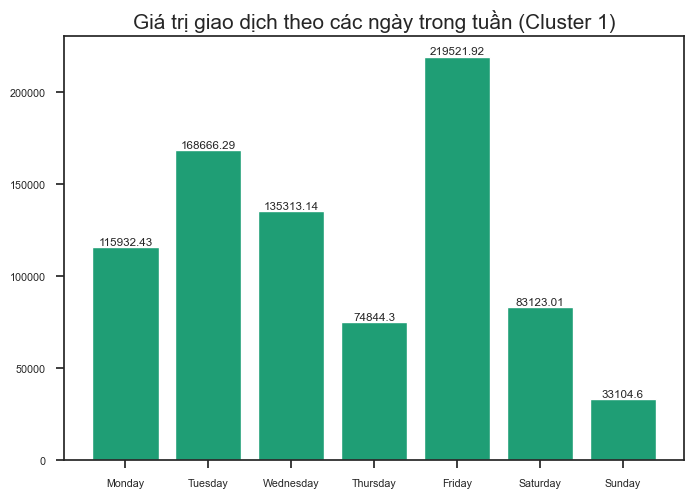

In [152]:
trans_data_label['weekdaynum']= trans_data_label['date'].dt.isocalendar().week
trans_data_label['weekday']= trans_data_label['date'].dt.strftime('%A')
grouped_data = trans_data_label[trans_data_label['Cluster'] == 1].groupby('weekday')['volume'].sum()
grouped_data = pd.DataFrame(grouped_data).reset_index()
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
grouped_data['weekday'] = pd.Categorical(grouped_data['weekday'], categories=cats, ordered=True)
plt.bar(data = grouped_data.sort_values(by= 'weekday'), x = 'weekday', height = 'volume')
for i, value in enumerate(grouped_data.sort_values(by= 'weekday')['volume']):
    plt.text(i, value, str(round(value,2)), ha='center', va='bottom')
plt.title('Giá trị giao dịch theo các ngày trong tuần (Cluster 1)', fontdict={'fontsize': 15})
plt.show()

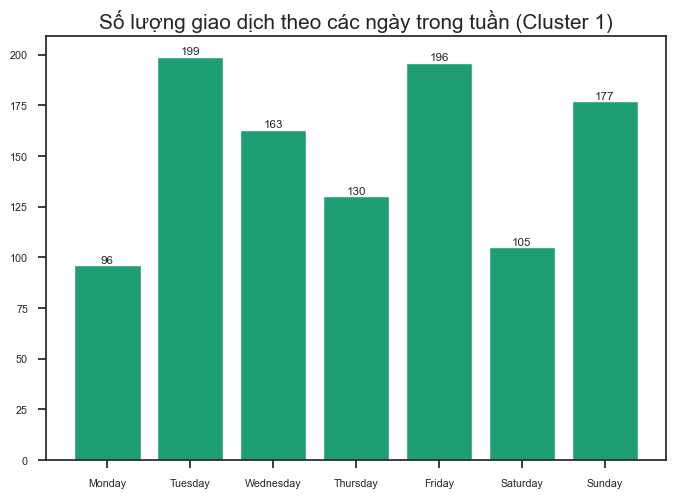

In [153]:
grouped_data = trans_data_label[trans_data_label['Cluster'] == 1].groupby('weekday')['user_id'].count()
grouped_data = pd.DataFrame(grouped_data).reset_index()
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
grouped_data['weekday'] = pd.Categorical(grouped_data['weekday'], categories=cats, ordered=True)
plt.bar(data = grouped_data.sort_values(by= 'weekday'), x = 'weekday', height = 'user_id')
for i, value in enumerate(grouped_data.sort_values(by= 'weekday')['user_id']):
    plt.text(i, value, str(round(value,2)), ha='center', va='bottom')
plt.title('Số lượng giao dịch theo các ngày trong tuần (Cluster 1)', fontdict={'fontsize': 15})
plt.show()

-> Số lượng giao dịch phân bố đều giữa các ngày trong tuần nhưng giá trị giao dịch vòa những ngày cuối tuần giảm khá nhiều

###### Nhóm 2

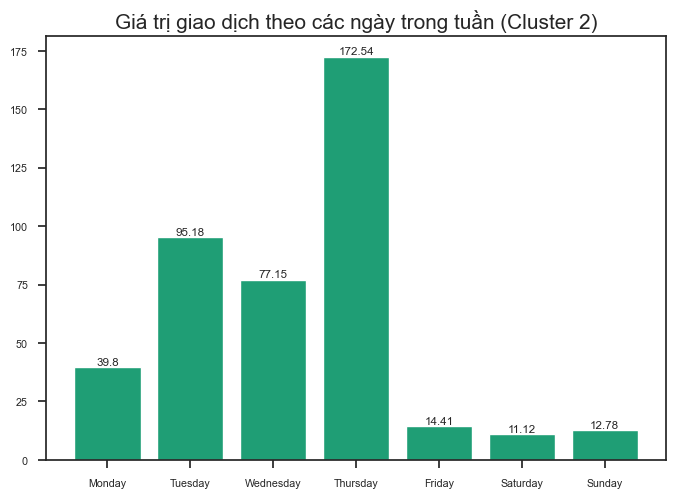

In [154]:
trans_data_label['weekdaynum']= trans_data_label['date'].dt.isocalendar().week
trans_data_label['weekday']= trans_data_label['date'].dt.strftime('%A')
grouped_data = trans_data_label[trans_data_label['Cluster'] == 2].groupby('weekday')['volume'].sum()
grouped_data = pd.DataFrame(grouped_data).reset_index()
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
grouped_data['weekday'] = pd.Categorical(grouped_data['weekday'], categories=cats, ordered=True)
plt.bar(data = grouped_data.sort_values(by= 'weekday'), x = 'weekday', height = 'volume')
for i, value in enumerate(grouped_data.sort_values(by= 'weekday')['volume']):
    plt.text(i, value, str(round(value,2)), ha='center', va='bottom')
plt.title('Giá trị giao dịch theo các ngày trong tuần (Cluster 2)', fontdict={'fontsize': 15})
plt.show()

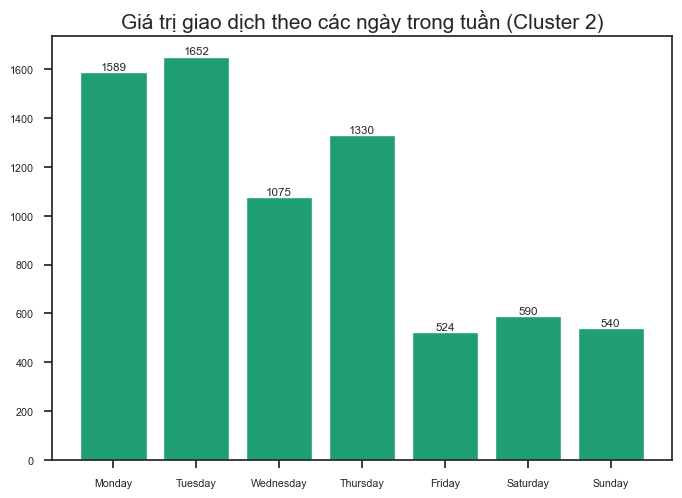

In [155]:
grouped_data = trans_data_label[trans_data_label['Cluster'] == 2].groupby('weekday')['user_id'].count()
grouped_data = pd.DataFrame(grouped_data).reset_index()
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
grouped_data['weekday'] = pd.Categorical(grouped_data['weekday'], categories=cats, ordered=True)
plt.bar(data = grouped_data.sort_values(by= 'weekday'), x = 'weekday', height = 'user_id')
for i, value in enumerate(grouped_data.sort_values(by= 'weekday')['user_id']):
    plt.text(i, value, str(round(value,2)), ha='center', va='bottom')
plt.title('Giá trị giao dịch theo các ngày trong tuần (Cluster 2)', fontdict={'fontsize': 15})
plt.show()

Có sự khác biệt rõ rệt giữa giá trị giao dịch lẫn số lượng giao dịch giữa cuối tuần và các ngày thường của cluster 2

###### Nhóm 3

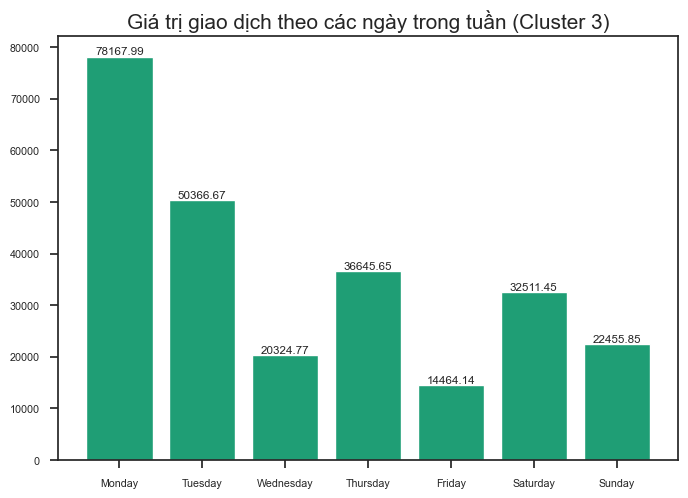

In [156]:
trans_data_label['weekdaynum']= trans_data_label['date'].dt.isocalendar().week
trans_data_label['weekday']= trans_data_label['date'].dt.strftime('%A')
grouped_data = trans_data_label[trans_data_label['Cluster'] == 3].groupby('weekday')['volume'].sum()
grouped_data = pd.DataFrame(grouped_data).reset_index()
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
grouped_data['weekday'] = pd.Categorical(grouped_data['weekday'], categories=cats, ordered=True)
plt.bar(data = grouped_data.sort_values(by= 'weekday'), x = 'weekday', height = 'volume')
for i, value in enumerate(grouped_data.sort_values(by= 'weekday')['volume']):
    plt.text(i, value, str(round(value,2)), ha='center', va='bottom')
plt.title('Giá trị giao dịch theo các ngày trong tuần (Cluster 3)', fontdict={'fontsize': 15})
plt.show()

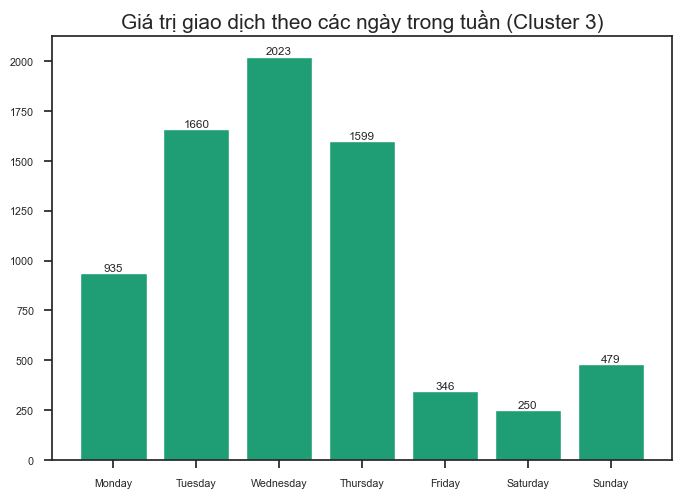

In [157]:
grouped_data = trans_data_label[trans_data_label['Cluster'] == 3].groupby('weekday')['user_id'].count()
grouped_data = pd.DataFrame(grouped_data).reset_index()
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
grouped_data['weekday'] = pd.Categorical(grouped_data['weekday'], categories=cats, ordered=True)
plt.bar(data = grouped_data.sort_values(by= 'weekday'), x = 'weekday', height = 'user_id')
for i, value in enumerate(grouped_data.sort_values(by= 'weekday')['user_id']):
    plt.text(i, value, str(round(value,2)), ha='center', va='bottom')
plt.title('Giá trị giao dịch theo các ngày trong tuần (Cluster 3)', fontdict={'fontsize': 15})
plt.show()

Giống như nhóm 2, giá trị giao dịch và số lượng giao dịch của nhóm 3 cũng có xu hướng giảm rõ rệt vào cuối tuần

###### Nhóm 4

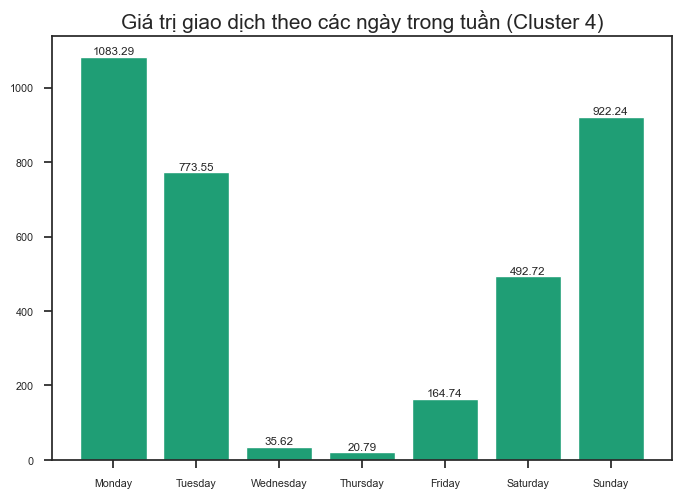

In [158]:
trans_data_label['weekdaynum']= trans_data_label['date'].dt.isocalendar().week
trans_data_label['weekday']= trans_data_label['date'].dt.strftime('%A')
grouped_data = trans_data_label[trans_data_label['Cluster'] == 4].groupby('weekday')['volume'].sum()
grouped_data = pd.DataFrame(grouped_data).reset_index()
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
grouped_data['weekday'] = pd.Categorical(grouped_data['weekday'], categories=cats, ordered=True)
plt.bar(data = grouped_data.sort_values(by= 'weekday'), x = 'weekday', height = 'volume')
for i, value in enumerate(grouped_data.sort_values(by= 'weekday')['volume']):
    plt.text(i, value, str(round(value,2)), ha='center', va='bottom')
plt.title('Giá trị giao dịch theo các ngày trong tuần (Cluster 4)', fontdict={'fontsize': 15})
plt.show()

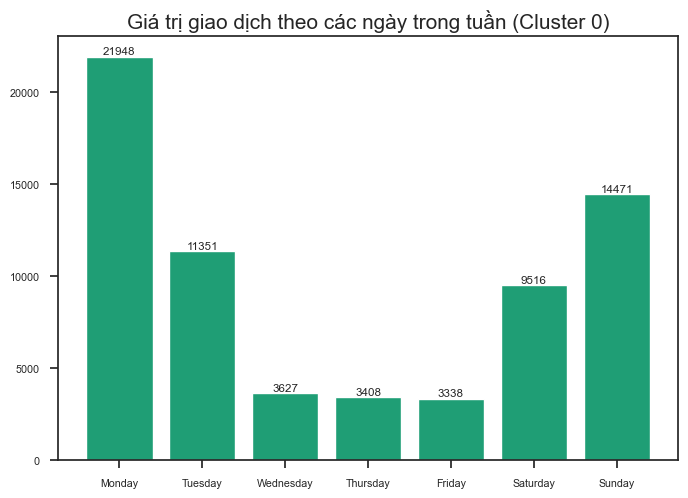

In [159]:
grouped_data = trans_data_label[trans_data_label['Cluster'] == 4].groupby('weekday')['user_id'].count()
grouped_data = pd.DataFrame(grouped_data).reset_index()
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
grouped_data['weekday'] = pd.Categorical(grouped_data['weekday'], categories=cats, ordered=True)
plt.bar(data = grouped_data.sort_values(by= 'weekday'), x = 'weekday', height = 'user_id')
for i, value in enumerate(grouped_data.sort_values(by= 'weekday')['user_id']):
    plt.text(i, value, str(round(value,2)), ha='center', va='bottom')
plt.title('Giá trị giao dịch theo các ngày trong tuần (Cluster 0)', fontdict={'fontsize': 15})
plt.show()

-> Nhóm 4 có sự suy giảm rõ rệt về chất lẫn lượng vào những ngày giữa tuần

## 6.4 App using behavior

##### Trung bình thời gian của mỗi session

In [160]:
user_data_label['Total time'] = user_data_label['time_per_session']*user_data_label['session']

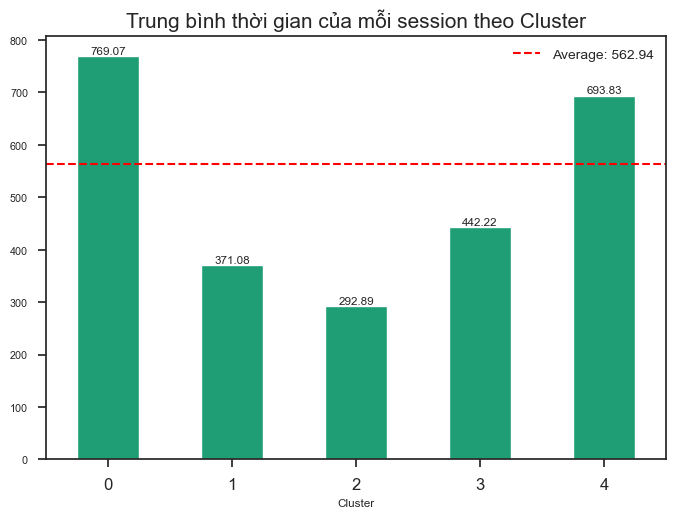

In [161]:
ax = (user_data_label.groupby('Cluster')['Total time'].sum()/user_data_label.groupby('Cluster')['session'].sum()).plot.bar()
for patch in ax.patches:
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_height()
    value = patch.get_height()
    text = f'{round(value,2)}'  # Format the value as desired
    ax.text(x, y, text, ha='center', va='bottom')
average = (user_data_label['Total time'].sum()/user_data_label['session'].sum()).mean()
ax.axhline(average, color='red', linestyle='--',  label='Average: {:.2f}'.format(average))

ax.tick_params(axis='x', rotation=0, labelsize = 12)
ax.legend(fontsize = 10)
ax.set_title('Trung bình thời gian của mỗi session theo Cluster', fontdict={'fontsize' : 15})
plt.show()

Cluster 0 và 4 có thời gian trung bình mỗi session cao hơn các nhóm khác khá nhiều 

Cluster 2 có thời gian sử dụng ví K trên mỗi session ít nhất

##### Trung bình số Feature sủ dụng trên mỗi Session 

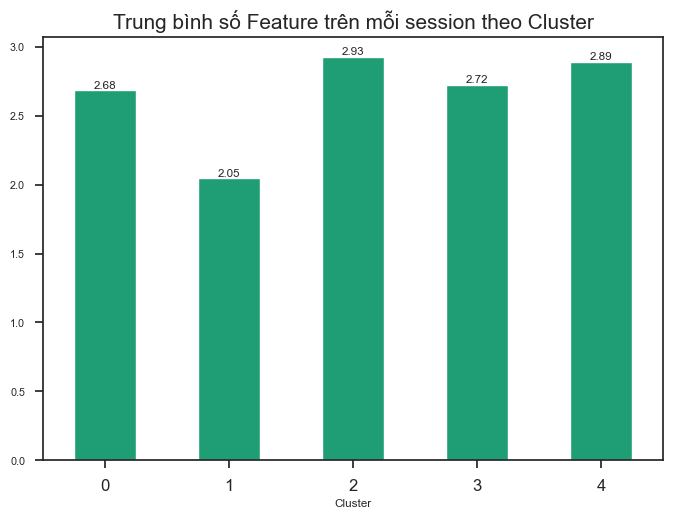

In [162]:
ax = (user_data_label.groupby('Cluster')['feature'].sum()/user_data_label.groupby('Cluster')['session'].sum()).plot.bar()
for patch in ax.patches:
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_height()
    value = patch.get_height()
    text = f'{round(value,2)}'  # Format the value as desired
    ax.text(x, y, text, ha='center', va='bottom')
average = (user_data_label['Total time'].sum()/user_data_label['session'].sum()).mean()

ax.tick_params(axis='x', rotation=0, labelsize = 12)
ax.set_title('Trung bình số Feature trên mỗi session theo Cluster', fontdict={'fontsize' : 15})
plt.show()

-> Không có sự khác biệt lớn về số lượng feature được sử dụng mỗi session giữa các cluster khác nhau

##### Trung bình Tổng Session của mỗi user

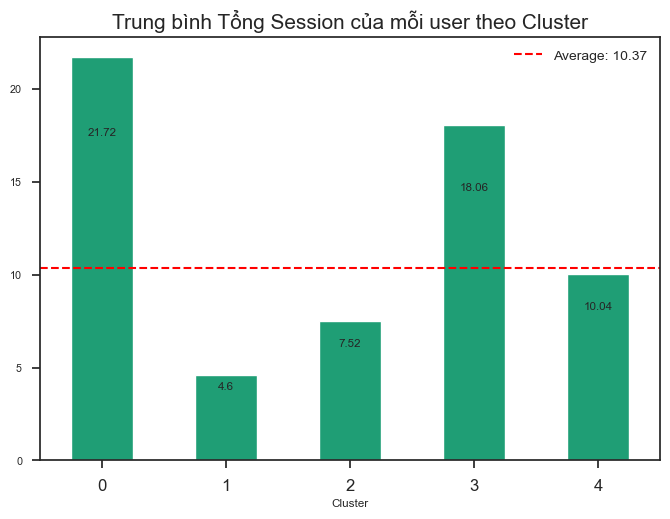

In [163]:
ax = (user_data_label.groupby('Cluster')['session'].sum()/user_data_label.groupby('Cluster')['user_id'].nunique()).plot.bar()
for patch in ax.patches:
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_height() - patch.get_height()*0.2
    value = patch.get_height()
    text = f'{round(value,2)}'  # Format the value as desired
    ax.text(x, y, text, ha='center', va='bottom',)
average = ((user_data_label['session'].sum()/user_data_label['user_id'].nunique())).mean()
ax.axhline(average, color='red', linestyle='--',  label='Average: {:.2f}'.format(average))

ax.tick_params(axis='x', rotation=0, labelsize = 12)
ax.legend(fontsize = 10)
ax.set_title('Trung bình Tổng Session của mỗi user theo Cluster', fontdict={'fontsize' : 15})
plt.show()

-> Cluster 0 có tổng số session trên mỗi user lớn nhất và cũng có thời gian trên mỗi session là lớn nhất

-> Mặc dù cluster 3 có thời gian trung bình trên mỗi session khá ít nhưng họ lại có tổng số session trên mỗi người khá cao

##### App behivour theo thời gian

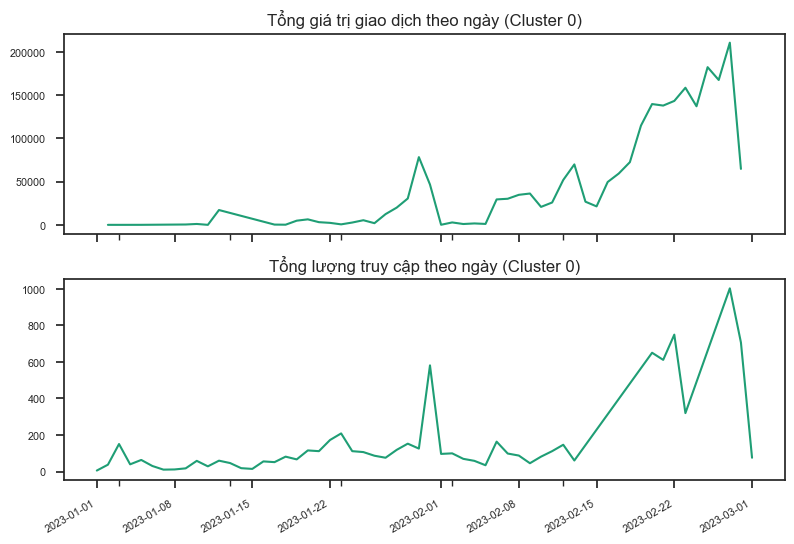

In [164]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex= True)
trans_data_label[trans_data_label['Cluster']==0].groupby('date')['volume'].sum().plot.line(ax = ax[0])
user_data_label[user_data_label['Cluster']==0].groupby('time')['session'].sum().plot.line(ax = ax[1])
ax[0].set_title('Tổng giá trị giao dịch theo ngày (Cluster 0)', fontsize = 12)
ax[1].set_title('Tổng lượng truy cập theo ngày (Cluster 0)', fontsize = 12)
ax[1].set_xlabel('')
plt.tight_layout()

plt.show()

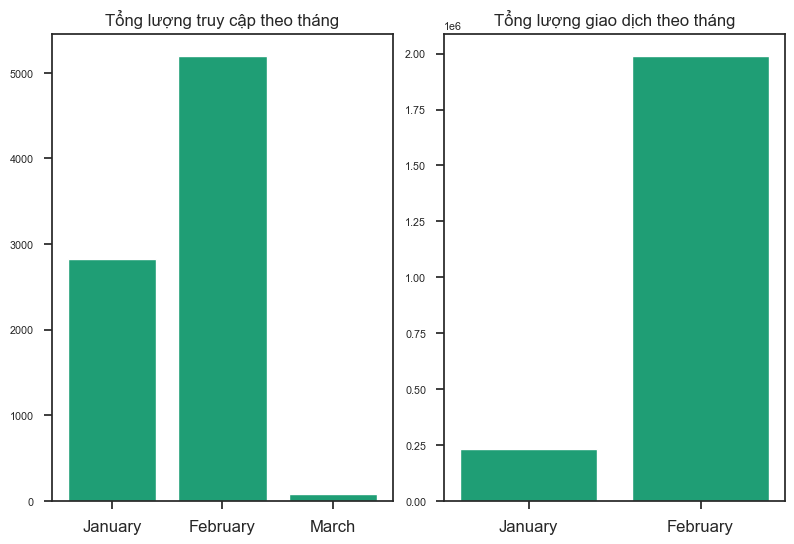

In [165]:
fig, ax =  plt.subplots(nrows=1, ncols=2)
t_user = user_data_label[user_data_label['Cluster']==0].groupby(pd.Grouper(key = 'time', freq = 'M')).agg({'session':'sum'}).reset_index()
t_trans = trans_data_label[trans_data_label['Cluster']==0].groupby(pd.Grouper(key = 'date', freq = 'M')).agg({'volume':'sum'}).reset_index()
ax[0].bar(t_user['time'].dt.strftime('%B'), t_user['session'])
ax[1].bar(t_trans['date'].dt.strftime('%B'), t_trans['volume'])
ax[0].tick_params(axis= 'x', labelsize = 12)
ax[1].tick_params(axis= 'x', labelsize = 12)
ax[0].set_title('Tổng lượng truy cập theo tháng', fontsize = 12)
ax[1].set_title('Tổng lượng giao dịch theo tháng', fontsize = 12)
plt.tight_layout()
plt.show()

-> Cluster 0 có xu hướng hoạt động mạnh vào cuối tháng và lượng giao dịch cũng như truy cập của tháng 2 nhiều hơn rất nhiều so với tháng 1

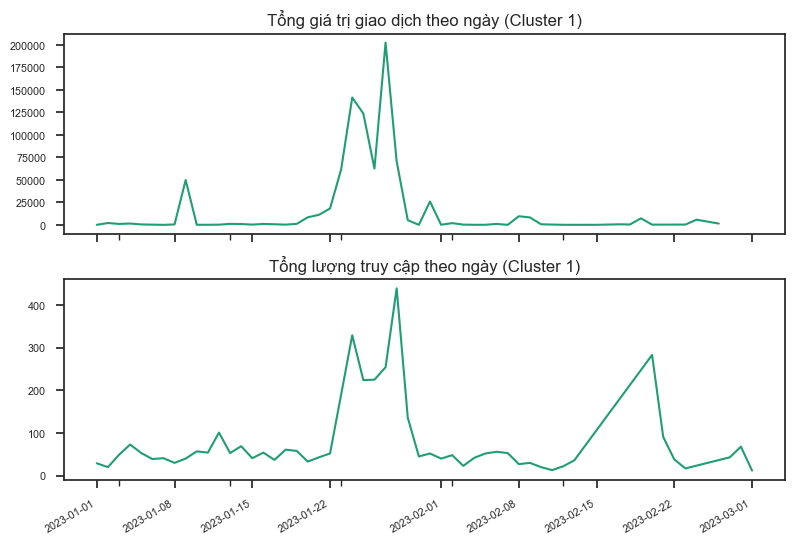

In [166]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex= True)
trans_data_label[trans_data_label['Cluster']==1].groupby('date')['volume'].sum().plot.line(ax = ax[0])
user_data_label[user_data_label['Cluster']==1].groupby('time')['session'].sum().plot.line(ax = ax[1])
ax[0].set_title('Tổng giá trị giao dịch theo ngày (Cluster 1)', fontsize = 12)
ax[1].set_title('Tổng lượng truy cập theo ngày (Cluster 1)', fontsize = 12)
ax[1].set_xlabel('')
plt.tight_layout()
plt.show()

-> Mặc dù tháng 1 chiếm phần lớn số lượng giao dịch nhưng users trong Cluster 1 vẫn hoạt động đều ở tháng 2

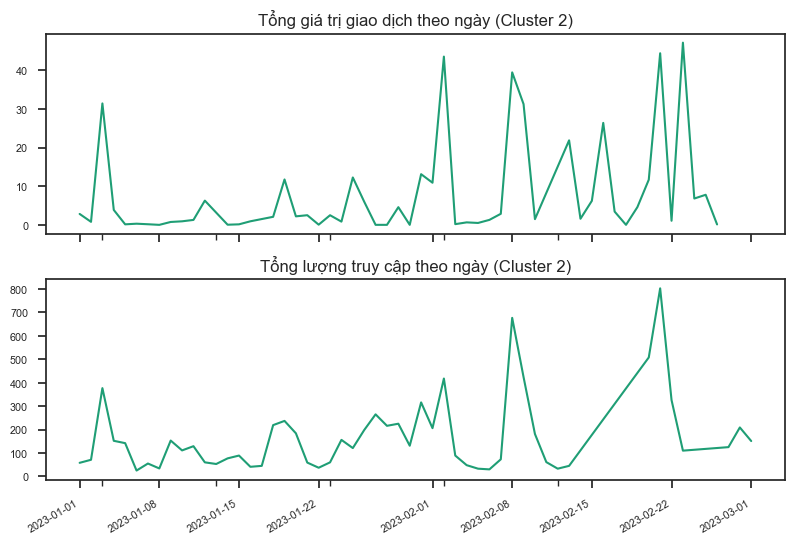

In [167]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex= True)
trans_data_label[trans_data_label['Cluster']==2].groupby('date')['volume'].sum().plot.line(ax = ax[0])
user_data_label[user_data_label['Cluster']==2].groupby('time')['session'].sum().plot.line(ax = ax[1])
ax[0].set_title('Tổng giá trị giao dịch theo ngày (Cluster 2)', fontsize = 12)
ax[1].set_title('Tổng lượng truy cập theo ngày (Cluster 2)', fontsize = 12)
ax[1].set_xlabel('')
plt.tight_layout()
plt.show()

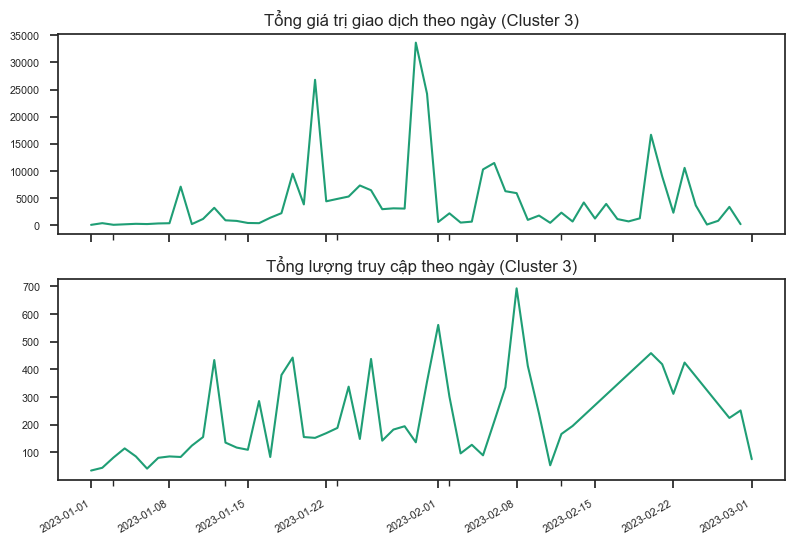

In [168]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex= True)
trans_data_label[trans_data_label['Cluster']==3].groupby('date')['volume'].sum().plot.line(ax = ax[0])
user_data_label[user_data_label['Cluster']==3].groupby('time')['session'].sum().plot.line(ax = ax[1])
ax[0].set_title('Tổng giá trị giao dịch theo ngày (Cluster 3)', fontsize = 12)
ax[1].set_title('Tổng lượng truy cập theo ngày (Cluster 3)', fontsize = 12)
ax[1].set_xlabel('')
plt.tight_layout()
plt.show()

-> Nhóm 2,3 có giá trị giao dịch cũng như tần suất haojt động khá đều trong cả hai tháng

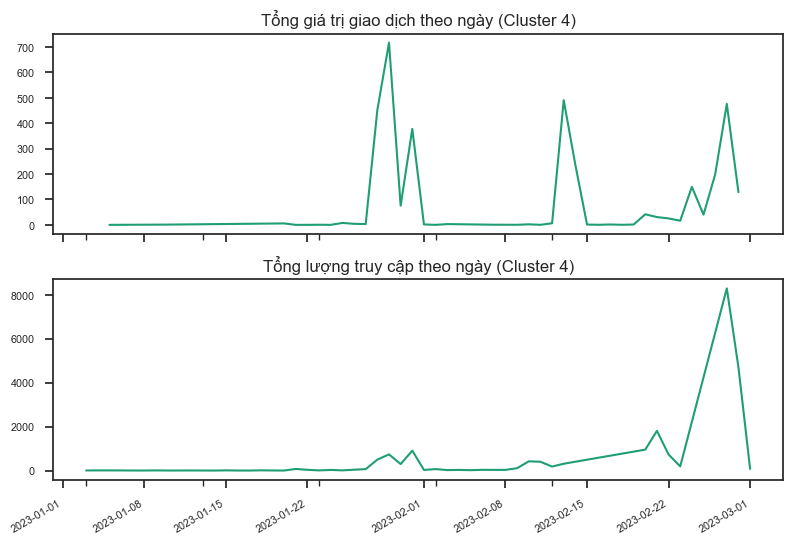

In [169]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex= True)
trans_data_label[trans_data_label['Cluster']==4].groupby('date')['volume'].sum().plot.line(ax = ax[0])
user_data_label[user_data_label['Cluster']==4].groupby('time')['session'].sum().plot.line(ax = ax[1])
ax[0].set_title('Tổng giá trị giao dịch theo ngày (Cluster 4)', fontsize = 12)
ax[1].set_title('Tổng lượng truy cập theo ngày (Cluster 4)', fontsize = 12)
ax[1].set_xlabel('')
plt.tight_layout()
plt.show()

-> Nhóm 4 có xu hướng giao dịch và hoạt động vào cuối tháng

## 6.5 Conclusion

### Cluster 0: Professional trader and Venezuelan

#### Vị trí địa lý

+ Hơn 50% lượng truy cập đến từ Venezuela và chiếm 65% tổng lượng giao dịch của nhóm.
<br>
 + Lượng truy cập từ Indonesia và Việt Nam chiếm lần lượt 17% và 12%. 

#### Thói quen giao dịch

+ Recency: 1.93 (Thấp) <br>
+ Frequency: 136.87 (Cao nhất) <br>
+ Monetary Value: 5962.28 (Cao nhất)


+ Tổng giá tri giao dịch của của mỗi người trong nhóm 0 lớn (hàng nghìn $), tuy nhiên họ chia thành nhiều giao dịch và giao dịch thường xuyên.
<br>
+ Trung bình số lượng giao dịch trong một ngày khá nhiều (Cao thứ hai sau nhóm 4)
<br>
-> Dựa vào hành vi giao dịch, nhóm THS phỏng đoán đây là nhóm những nhà đầu tư dựa vào tỷ lệ chênh lệch giữa giá mua và giá bán, giao dịch thường cuyên ngay khi phát hiện cơ hội kiếm lãi.


#### Thói quen sử dụng app

+ Thời lượng trung bình mỗi lần đăng nhập: 769 giây (lâu nhất)
+ Số lượng tính năng sử dụng mỗi lần đăng nhập: 2.68
+ Trung bình tổng session trên mõi user:  21.72 ( Lớn nhất)

#### Insight

Do <b>  sự khác biệt </b> về yếu tố <b>kinh tế  </b>lẫn <b> chính trị </b> của Venezuela với các nước còn lại, trong cluster 0 sẽ tiếp tục được chia thành <b> 2 sub-segment </b> khác nhau là các <b>users ở Venezuela </b> và  <b>users ở các nước còn lại. </b>

<b> Venezuela: </b> <br>
+ Tần suất giao dịch lớn hơn các nước khác trong cùng một nhóm. <br>
+ Giá trị giao dịch trung bình của một người cũng lớn hơn (so với các quốc gia có nhiều giao dịch). <br>
+ Số lượng tính năng trung bình được sử dụng bởi một người nhiều hơn các nhóm khác.

<b>Pro traders:</b>
+ Giá trị của mỗi giao dịch ở mức trung bình tuy nhiên tần suất giao dịch rất lớn. 
+ Trung bình một người trong tiêu nhiều tiền hơn những cluster khác khá nhiều.


#### Đề xuất 

<b> Venezuela: </b> <br>
+ Video hướng dẫn, giới thiệu về thị trường crypto, đầu tư, video hướng dẫn về giao dịch trên ví K.
+ Chương trình giới thiệu.
+ Hợp tác với các dịch vụ chuyển tiền crypto. 

<b>Pro traders:</b>
+ Giảm phí khi giao dịch.
+ Cơ chế hoàn tiền, điểm thưởng.

### Cluster 1: The sage (Đầu tư thông thái)

#### Vị trí địa lý

+ Chủ yếu là lượng truy cập đền từ Việt Nam với hơn 70% và Việt Nam cũng chiếm 85% lượng giao dịch của nhóm.
+ Lượng truy cập đến từ Indonesia chiếm 18% nhưng chiếm rất ít tỉ trọng lượng giao dịch.

#### Thói quen giao dịch

+ Recency: 31.64 (Cao nhất)
+ Frequency: 1.24 (Thấp nhất)
+ Monetary Value: 956.12 (cao thứ 2)


+ Người dùng trong nhóm có xu hướng giao dịch nhiều trong tháng 1 nhưng tháng 2 thì không nhiều.
+ Tần suất thực hiện giao dịch ít nhưng lượng chi tiêu trong mỗi giao dịch cao.
+ Lượng giao dịch phân bố chủ yếu vào các ngày thường trong tuần, các ngày cuối tuần rất ít.

#### Thói quen sử dụng app

+ Thời lượng trung bình mỗi lần đăng nhập: 371 giây (Thấp thứ 2)
+ Số lượng tính năng sử dụng mỗi lần đăng nhập: 2 (Thấp nhất)
+ Trung bình tổng session trên mỗi user: 4.6 (cao nhất)

#### Insight

+ Tần suất giao dịch thấp nhất nhưng có giá trị giao dịch rất cao. 
+ Khoảng thời gian ghi nhận lần thực hiện giao dịch gần nhất là 31 ngày nhưng người dùng sau đó vẫn tiếp tục sử dụng ứng dụng và đang chờ cơ hội kế tiếp để giao dịch. Do đó họ vẫn còn hoạt động trên ví K.
+ Số lượng tính năng trung bình và tổng lượt đăng nhâp được sử dụng bởi một người thấp nhất so với các nhóm còn lại.
+ Thời lượng sử dụng ví K mỗi lần đăng nhập cũng là  thấp nhất so với các nhóm còn lại.

#### Đề xuất 

+ Portfolio cho mỗi người.
+ Tạo dựng cộng đồng.
+ Tin tức và phân tích thị trường.
+ Thông báo theo chủ đề quan tâm.

### Cluster 2: The security seeker 

#### Vị trí địa lý

+ Đa số lượng truy cập đến từ các quốc gia đang phát triển của khu vực Nam Á Và Đông Nam Á như Pakistan, Indonesia, Bangladesh (chiếm hơn 73%) và chiếm gần 50% tổng lượng giao dịch của nhóm. 


#### Thói quen giao dịch

+ Recency: 15.12
+ Frequency: 6.27
+ Monetary Value: 0.36 (Thấp nhất)


+ Toàn bộ các giao dịch đều có giá trị nhỏ hơn 10 USD. Giá trị trung bình mỗi giao dịch 0.06 USD (Thấp thứ 2) và hầu hết các giao dịch dưới 0.00005 USD. 
+ Lượng giao dịch cao thường xuất hiện vào các ngày trong tuần, đặc biệt là thứ 3, 4, 5. 
+ Hầu hết các giao dịch được thực hiện trên android

#### Thói quen sử dụng app

+ Thời lượng trung bình mỗi lần đăng nhập: 293 giây (thấp nhất)
+ Số lượng tính năng sử dụng mỗi lần đăng nhập: 2.93
+ Trung bình tổng session trên mỗi user: 7.52 (Thấp thứ 2)

#### Insight

+ Tần suất giao dịch thấp.
+ Thời gian trung bình mỗi lần đăng nhập là nhỏ nhất so với những cluster còn lại. 
+ Trung bình một người trong nhóm này cũng đăng nhập khá ít vào ứng dụng

#### Đề xuất 

+ Nâng cấp tính bảo mật cho hệ thống.
+ Nâng cấp dịch vụ chăm sóc khách hàng.

### Cluster 3: The rising star

#### Vị trí địa lý

+ Hơn 37% lượng user từ Indonesia, tiếp đó là India và Bangladesh với lần lượt hơn 18% và xấp xỉ 14% lượng user trong cluster. Hai nước còn lại trong top 5 là Việt Nam và Venezuela
+ Tuy nhiên, Việt Nam và Venezuela là lại là 2 nước có lượng giao dịch lớn nhất chiếm gần 33% tổng lượng giao dịch và gần 17% tổng lượng giao dịch, trong khi Indo chỉ chiếm hơn 3%.

#### Thói quen giao dịch

+ Recency: 12.45 (Trung bình)
+ Frequency: 11.48 (Trung bình)
+ Monetary Value: 411.43 (Cao)


+ Giá trị giao dịch tương đối cao. Đa số (> 98%) có giá trị giao dịch nhỏ hơn 100USD. Giá trị trung bình mỗi giao dịch 34$.
+ Lượng giao dịch cao thường xuất hiện vào những ngày cuối tuần và đầu tuần.
+ Có giá trị giao dịch cao và trung bình lần giao dịch gần nhất cách gần thời điểm ghi nhận 12 ngày

#### Thói quen sử dụng app

+ Thời lượng trung bình mỗi lần đăng nhập: 422 giây
+ Số lượng tính năng sử dụng mỗi lần đăng nhập: 2.72
+ Trung bình tổng session trên mỗi user: 18.06 (Cao)

#### Insight

+ Nhóm người dùng tiềm năng để khai thác thêm, gia tăng giá trị giao dịch cũng như tần suất giao dịch của họ.
+ Mặc dù nhóm này có thời gian trung bình trên mỗi session thấp hơn mức trung bình của toàn ví nhưng tổng số session trên mỗi người khá cao, điều này chứng minh họ vẫn thường xuyên sử dụng ví.

#### Đề xuất 

+ Hệ thống điểm thưởng và phân hạng người dùng dựa trên điểm tích lũy.

### Cluster 4: The chancy

#### Vị trí địa lý

+ Brazil, France, United States, Spain là 4 quốc gia có lượng user và lượng giao dịch cao nhất. 
+ Trung bình mức giao dịch của mỗi nước này không có sự khác biệt lớn (khoảng 3$/người)

#### Thói quen giao dịch

+ Recency: 2.02 (Rất thấp)
+ Frequency: 32.02 (Cao)
+ Monetary Value: 1.65 (Thấp)


+ Có số lượng người dùng nhiều nhất trong cả 5 nhóm.
+ Lượng giao dịch nhìn chung rất nhỏ. Trung bình mỗi giao dịch 0.05$, hầu hết dưới 0.01.
+ Thường giao dịch vào 2 ngày cuối tuần và 2 ngày đầu tuần

#### Thói quen sử dụng app

+ Thời lượng trung bình mỗi lần đăng nhập: 422 giây
+ Số lượng tính năng sử dụng mỗi lần đăng nhập: 2.72
+ Trung bình tổng session trên mỗi user: 18.06 (Cao)

#### Insight

+ Số lượng user nhiều nhất.
+ Recency thấp và Frequency cao.
+ Giá trị giao dịch không nhiều nhưng tần suất giao dịch nhiều
+ Có nhiều user_id thay đổi Vpn.
+ Độ dài trung bình mỗi session của nhóm này khá cao
+ Thường có xu hướng trade vào cuối tháng

#### Đề xuất 

+ Hệ thống đề xuất (recommendation system) những loại tiền ảo phù hợp với khẩu vị của từng nhóm